## Chapter 11: Principles of Feature Learning

# 11.3 Efficient cross-validation via boosting

In this Section we introduce boosting - the first of two fundamental paradigms for effective cross-validation. With boosting we take a 'bottom-up' approach to fine tuning the proper amount of capacity by sequentially adding one unit at-a-time to our model. In other words, we begin with a very *low capacity* model (just a bias) and gradually increase its capacity by adding additional units (from the same family of universal approximators), one unit at-a-time, until we achieve a model with minimal validation error.

While in principle any universal approximator can be used with boosting, this approach is often used as the cross-validation method of choice when employing tree-based universal approximators, and in particular stumps.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer and other basic libs
import time
import copy
import math
from IPython.display import clear_output

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.1  Boosting based cross-validation: the big picture

With the general *boosting* procedure we perform cross-validation by constructing our model *one unit at-a-time*. In each *round of boosting* we add a single unit to our model and tune its parameters (and its parameters alone) optimally, keeping them fixed at these optimally tuned values forever more. Doing this we gradually increase the nonlinear capacity of our model, and can therefore determine an ideal model (one with *low validation error*) with high resolution. Moreover by adding one unit at-a-time and tuning *only the parameters corresponding to this new unit* we keep the optimization / training at each step roughly constant.  This tends to make boosting quite an effecient in practice. 

Using the dial visualization of cross-validation introduced in Section 11.2.2 we can think about the boosting procedure as starting with the dial set *all the way to the left* (at a model with extremely low capacity).  As we progress through rounds of boosting we are turning this dial very gradually clockwise from left to right, increasing the capacity of the model very gradually in search of a model with low validation error. 

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/boosting_dial.png' width="60%" height="70%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 1:</strong> <em> 
With boosting we begin with our cross-validation dial set all the way to the left - at an  extremely low capacity model - and gradually increases model capacity by adding one unit at-a-time (typically each unit being taken from the same family of universal approximators).   As each round of boosting progresses we slowly turn the dial clockwise from left to right, gradually increasing the model's capacity, in search of a model with minimum validation.
</em>
</figcaption>
</figure>

## 11.3.2 Choosing the right kind of units for boosting

As with all feature learning scenarios for the sake of both consistency and to better address the technical issues associated with each main type of universal approximator, with boosting we virtually always choose units from the same family of universal approximators.  Moreover whether we use kernel, neural network, or tree-based units we *prefer* units with *low capacity* for boosting.  Each of the basic examples given in Section 11.1.3 in introduce the three popular universal approximators fit this bill, being of low capacity compared to more advanced exemplars (e.g., deep neural networks and trees, which we detail in future Chapters) - polynomials (kernel), single layer networks (neural networks), and stumps (trees).  So for example, in the case of kernels monomials from a large degree polynomial can be chosen as units.  With neural networks each unit can be choosen as a single hidden layer unit, meaning each is a parameterized nonlinear function *of the same form* (as detailed in Section 11.1.2 and Chapter 13).  In the case of trees, a set of stumps (a very popular choice of universal approximator used with boosting due to how they are typically constructed) can be custom-built for a given dataset as described in Section 14.1. 

The main reason for preferring *low* capacity units with boosting - regardless of the type of universal approximator employed - is so that the resolution of our model search is as *high* as possible.  When we start adding units one-at-a-time, turning the cross-validation dial clockwise from left to right as detailed above, we want the dial to turn smoothly so that we can determine the lowest validation error model as finely as possible.  Using *high capacity* units at each round of boosting results in a coarse resolution for our model search, as we it roughly jerk it from left to right leaving large gaps in our model search.  This kind of low resolution search could easily result in us overshooting the ideal model.

<figure>
    <img src= '../../mlrefined_images/nonlinear_superlearn_images/jerky.png' width="100%"/>
</figure>

The same could be said as to why we add only one unit at-a-time, tuning its parameters alone at each round of boosting.  If we added more than one unit at-a-time, or instead re-turned *every* parameter of *every* unit at each step of this process not only would we have significantly more computation to perform at each step but this performance difference between subsequent models could be quite large, and we might miss out on an ideal model with low validation error.  In other words, by adding one unit-at-a-time our sequence of models does not overfit nearly as quickly as they would if we tuned all of the parameters of every unit simultaneously at each step of the process.

## 11.3.3 The general boosting algorithm

With boosting we start off with a set

\begin{equation}
\mathcal{F} = \{f_{1}\left(\mathbf{x}\right),\,f_{2}\left(\mathbf{x}\right),\,\ldots,\,f_B\left(\mathbf{x}\right)\}
\end{equation}

consisting of $B$ nonlinear features (or units), all taken from the same family of universal approximators (e.g., kernels, trees, or neural networks), and sequentially add them to a running model, one at-a-time, to construct a generic nonlinear model of the form  

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_{s_1}\left(\mathbf{x}\right){w}_{1} +  f_{s_2}\left(\mathbf{x}\right){w}_{2} + \cdots + f_{s_B}\left(\mathbf{x}\right)w_{B}
\end{equation}

where $f_{s_k}$ denotes the unit added at the $k^{th}$ round of this process. As usual, $w_0$ through $w_B$ along with any additional weights internal to $f_{s_1},\,f_{s_2},\,\ldots,\,f_{s_B}$ are represented collectively in the weight set $\Theta$.

The process of boosting is performed in a total of $B+1$ rounds, one for each summand of Equation (2). At each round we determine which unit, when added to the running model, best lowers its training error. We then measure the corresponding validation error provided by this update, and in the end, after all rounds of boosting are complete, use the lowest validation error measurement found to decide which round provided the best overall model.

### Boosting: round 0

Boosting is begun with the lowest capacity model imaginable, a bias-only model of the form

\begin{equation}
\text{model}_0^{\,}\left(\mathbf{x},\Theta_0\right) = w_0
\end{equation}

whose weight set $\Theta_0^{\,} = \left\{ w_0\right\}$ contains a single bias weight, which we can easily tune by minimizing an appropriate cost over this variable alone. Suppose hereinafter that we are interested in performing nonlinear regression on the training dataset $\left\{\left(\mathbf{x}_p,\,y_p\right)\right\}_{p=1}^P$ employing a Least Squares cost. The principles of boosting remain exactly the same for other learning tasks and their associated costs.


To find the optimal value for $w_0$ we minimize the Least Squares cost 

\begin{equation}
\frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x}_p,\Theta_0 \right)  - \overset{\,}{y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

giving the optimal value for $w_0$ which we denote as $w_0^{\star}$. We fix the bias weight at this value forever more throughout the process.

### Boosting: round 1

Having tuned the only parameter of $\text{model}_0$ we now *boost* its capacity by adding the term $f_{s_1}\left(\mathbf{x}\right)w_{1}$ to it, resulting in a modified running model which we call $\text{model}_1$  

\begin{equation}
\text{model}_1^{\,}\left(\mathbf{x},\Theta_1^{\,}\right) = \text{model}_0^{\,}\left(\mathbf{x},\Theta_0^{\,}\right) + f_{s_1}\left(\mathbf{x}\right)w_{1}
\end{equation}

To determine which unit in $\mathcal{F}$ (when its weight and internal parameters tuned appropriately) best lowers the training error, we press $\text{model}_1$ against the data by minimizing


\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x}_p,\Theta_0^{\,}\right) + f_{s_1}\left(\mathbf{x}_p^{\,}\right)w_1   - {y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + f_{s_1}\left(\mathbf{x}_p\right)w_1  - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

for every $f_{s_1} \in \mathcal{F}$. 

Notice, since the bias weight has already been set optimally in the previous round we only need tune the weight $w_{1}$ as well as the parameters internal to the nonlinear unit $f_{s_1}$. Also note that with neural networks all nonlinear units take *precisely the same form* and therefore we need not solve $B$ versions of the optimization problem above, one for every unit in $\mathcal{F}$, as we would do when using kernel or tree-based units. Regardless of the type of universal approximator employed, round 1 of boosting ends upon finding the optimal $f_{s_1}$ and its internal parameters as well as $w_1$, which we denote respectively as $f^{\star}_{s_1}$ and $w^{\star}_1$, and keep fixed moving forward.    

### Boosting: round $k>1$

In general the $k^{th}$ round of boosting follows the same pattern outlined in round 1, wherein through addition of the term $f_{s_k}\left(\mathbf{x}\right)w_{k}$ we aim to boost the capacity of our running model from round $k-1$


\begin{equation}
\text{model}_k^{\,}\left(\mathbf{x},\Theta_k^{\,}\right) = \text{model}_{k-1}^{\,}\left(\mathbf{x},\Theta_{k-1}^{\,}\right) + f_{s_k}\left(\mathbf{x}\right)w_{k}
\end{equation}


by minimizing (in the case of Least Squares regression)

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_{k-1}^{\,}\left(\mathbf{x}_p,\Theta_{k-1}^{\,}\right) + f_{s_k}\left(\mathbf{x}_p^{\,}\right)w_k   - {y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + \cdots + f^{\star}_{s_{k-1}}\left(\mathbf{x}_p\right)w_{k-1}^{\star} + f_{s_k}\left(\mathbf{x}_p\right)w_k  - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

over $w_k$, $f_{s_k}$ and its internal parameters (if they exist). 

Once again with kernel or tree-based approximators, this entails solving $B$ (or $B-k+1$, if we decide to discard units chosen in previous rounds) such optimization problems and choosing the one with smallest training error.   

### Boosting: choosing the best model

By the time all rounds of boosting are complete we have generated a sequence of $B+1$ models in total  $\left\{\text{model}_k\left(\mathbf{x},\Theta_k^{\,}\right)\right\}_{k=0}^B$ which progressively grow in nonlinear capacity from $k = 0$ to $k = B$. At the same time, as $k$ grows large the training error keeps diminishing which can be expressed algebraically as the following sequence of inequalities 

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_{k-1}^{\,}\left(\mathbf{x}_p,\Theta_{k-1}^{\,}\right)  - {y}_{p}^{\,}\right)^{2} \geq  \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_{k}^{\,}\left(\mathbf{x}_p,\Theta_{k}^{\,}\right)  - {y}_{p}^{\,}\right)^{2}
\end{equation}

for all $k = 1, 2, \ldots, B$.


Gradually increasing the nonlinear capacity with boosting gives us fine-grained control in selecting an appropriate model, as the difference in performance in terms of both the training and validation errors between subsequent models in this sequence can be quite smooth. We use the latter to choose the best performing model, the one with the smallest validation error of all. Denoting the validation set by $\mathcal{V}$ we have


\begin{equation}
k^{\star} = \underset{k}{\text{argmin}} \quad  \frac{1}{\left|\mathcal{V}\right|}\sum_{\left(\mathbf{x},\,y\right) \,\in\, \mathcal{V}}^{}\left(\text{model}_{k}^{\,}\left(\mathbf{x},\Theta_{k}^{\,}\right)  - {y}\right)^{2} 
\end{equation}

### Boosting: a cheap but effective enhancement

A slight adjustment to how we boost $\text{model}_{k-1}$, via addition of an individual bias $w_{0, k}$ 

\begin{equation}
\text{model}_k^{\,}\left(\mathbf{x},\Theta_k^{\,}\right) = \text{model}_{k-1}^{\,}\left(\mathbf{x},\Theta_{k-1}^{\,}\right) + w_{0, k} + f_{s_k}\left(\mathbf{x}\right)w_{k}
\end{equation}

results in greater flexibility and generally better overall performance by allowing units to be adjusted 'vertically' at each round (in the case of regression) at the minimal cost of adding a single variable to each optimization subproblem. 

Note that once tuning is done, the optimal bias weight $w^{\star}_{0, k}$ can be absorbed into the bias weights from previous rounds, creating a single bias weight $w^{\star}_{0}+w^{\star}_{0, 1}+\cdots +w^{\star}_{0, k}$ for the entire model.

Finally it is worth noting that each type of universal approximator (kernels, neural networks, and trees) comes with its own unique set of technical peculiarities that need be addressed for successful use in practice, including in the context of boosting. For example, as we detail in Section 13.1, the enhancement discussed above is redundant when using tree-based approximators as they already have individual bias terms 'baked in' to them. Many of such universal approximator-specific technical issues are detailed in the next three Chapters. 

#### <span style="color:#a50e3e;">Example 1. </span> Boosting regression using stump units

Here we show a simple example of boosting using stump features for regression.  In particular here we use the noisy sinusoidal dataset introduced in Example 1 of the previous Section, which consists of $P=21$ low dimensional points.  We construct a set of $B = 20$ stump features for this dataset as described in Section 14.1, and illustrate the result of $M = 100$ rounds of boosting (meaning that many of the stumps are used multiple times).  We split the dataset into $\frac{2}{3}$ training and $\frac{1}{3}$ validation, which are highlighted in light blue and yellow respectively in the left panel of the figure below.  As you move the slider from left to right the boosting steps proceed, with the resulting fit shown in the left panel with the original data (which is color-coded - blue for training and yellow for validation data) and corresponding training / validation errors shown in the right (with blue denoting training error and yellow validation error).  Notice how smooth the resolution of this boosting-based model search is in terms of how closely subsequent models match in terms of their training and validation errors.  This smooth search allows us to determine - with very high resolution - an ideal stump-based model for this dataset.


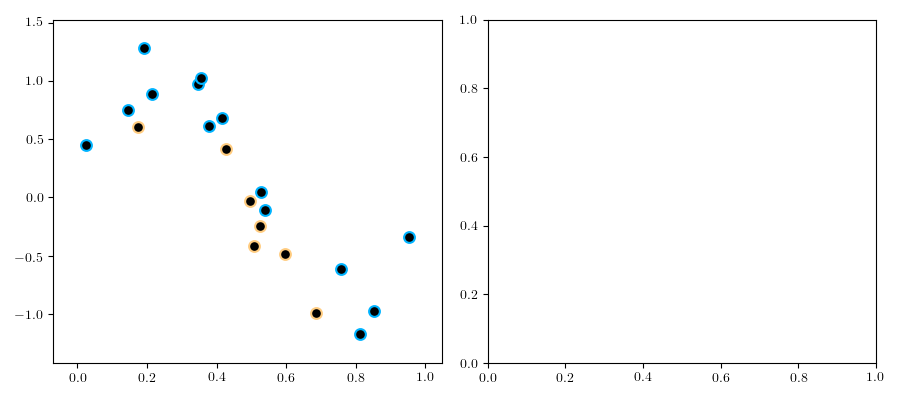
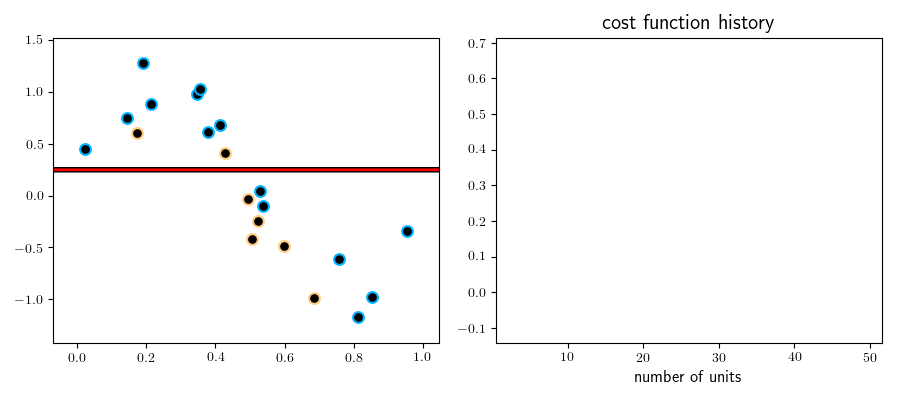
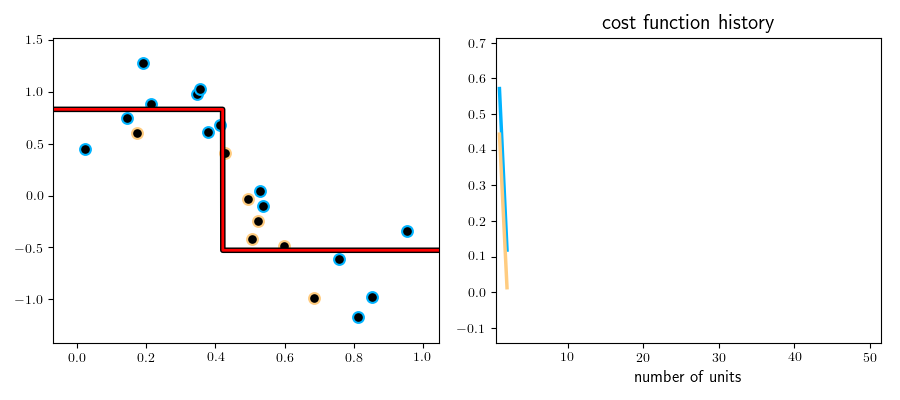
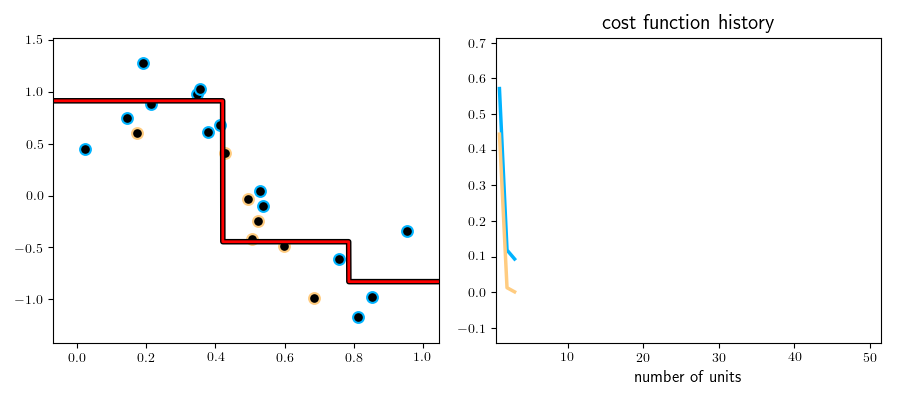
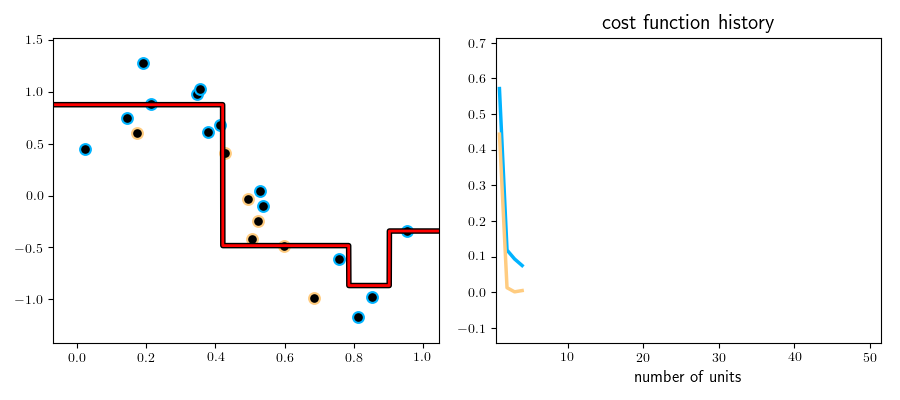
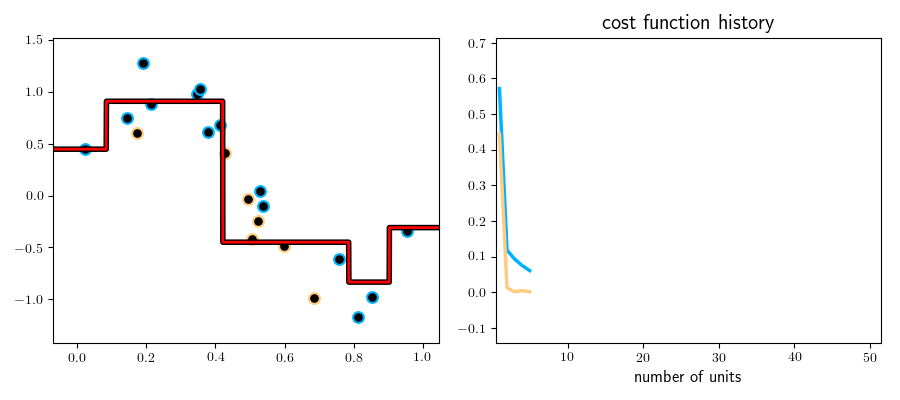
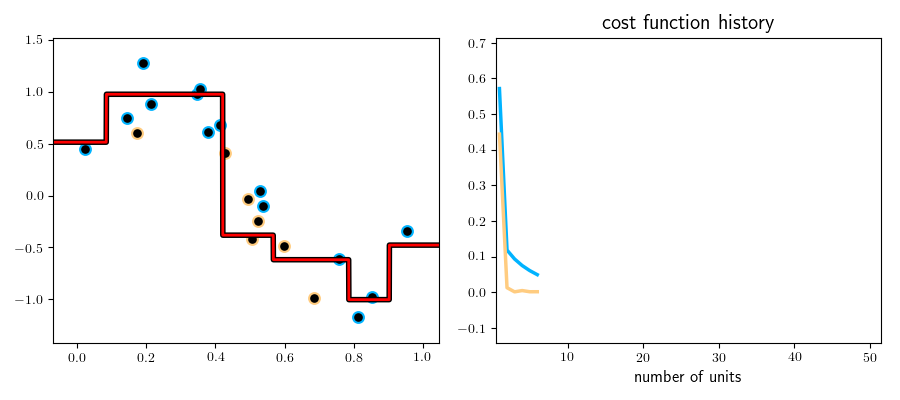
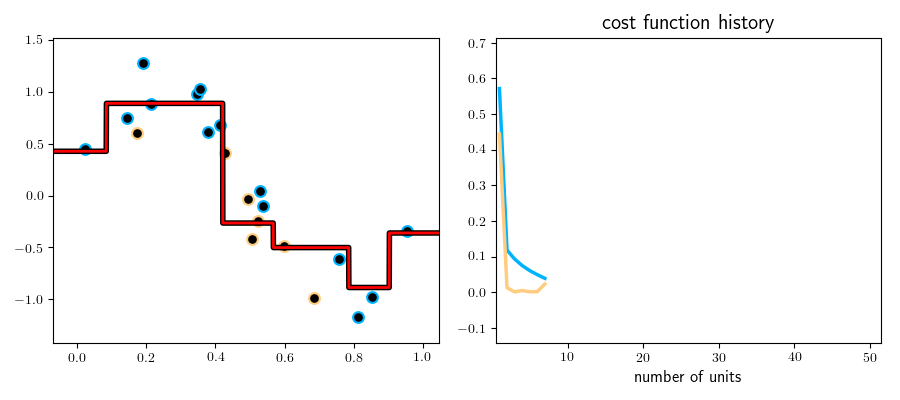
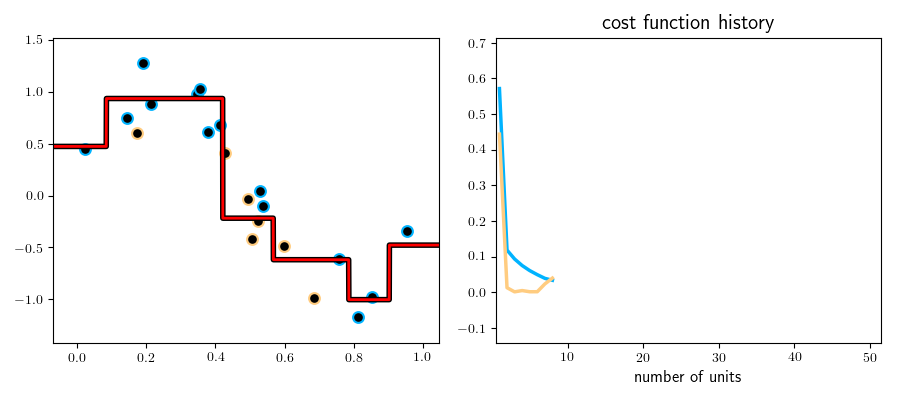
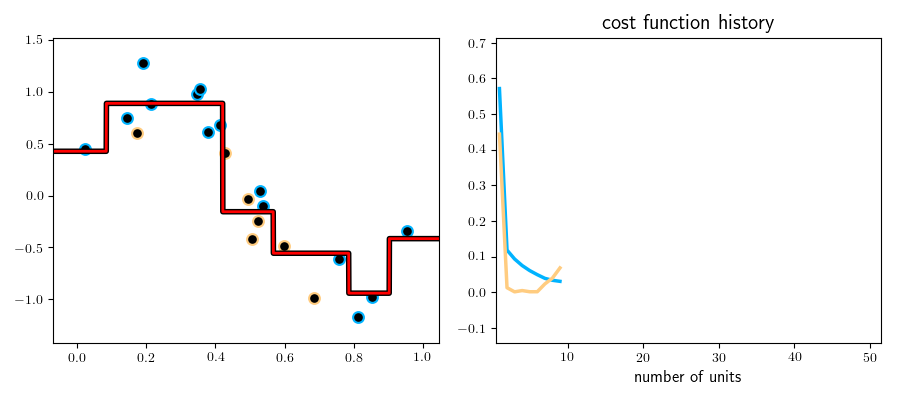
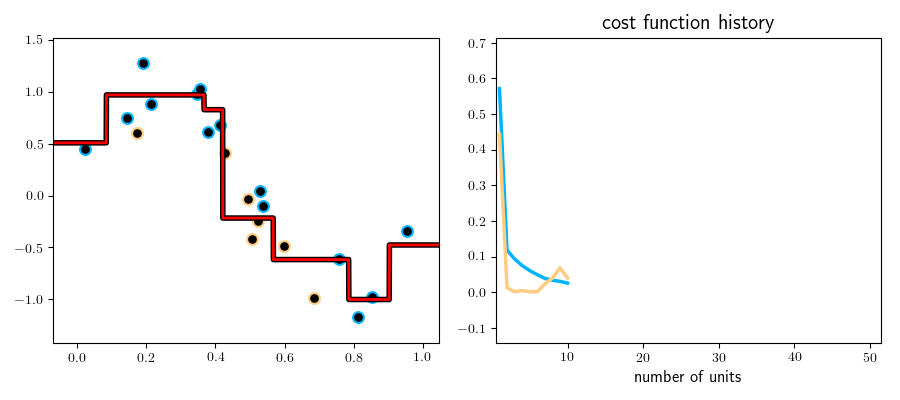
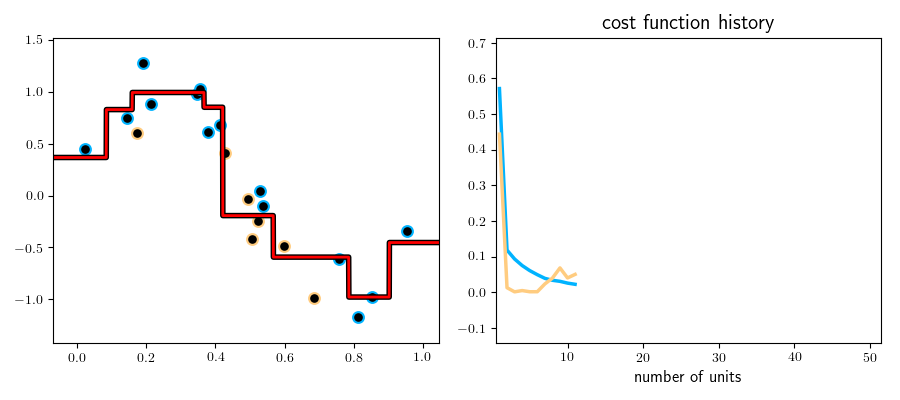
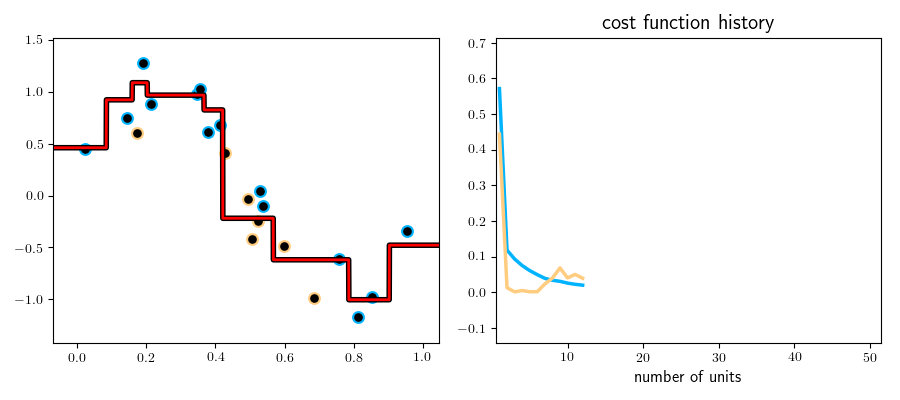
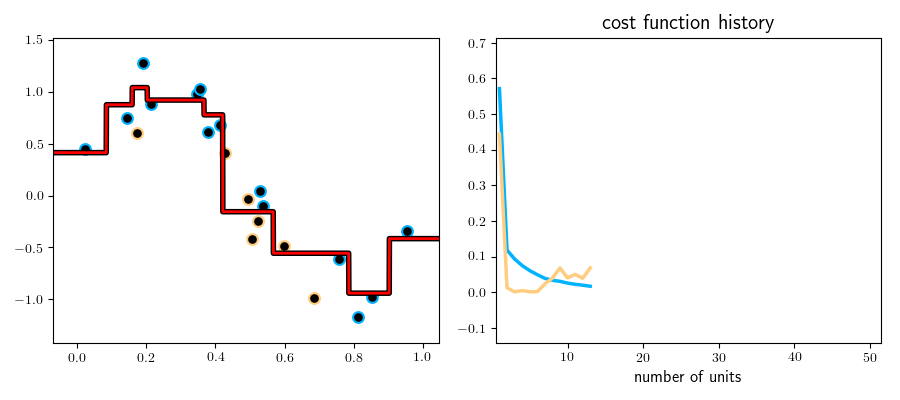
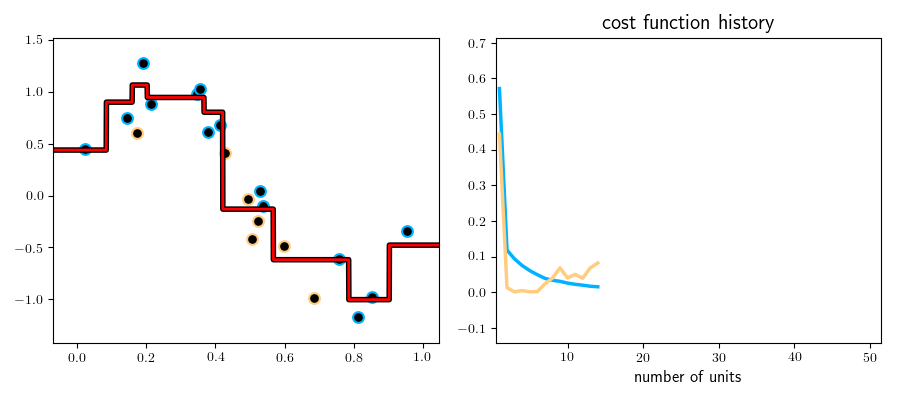
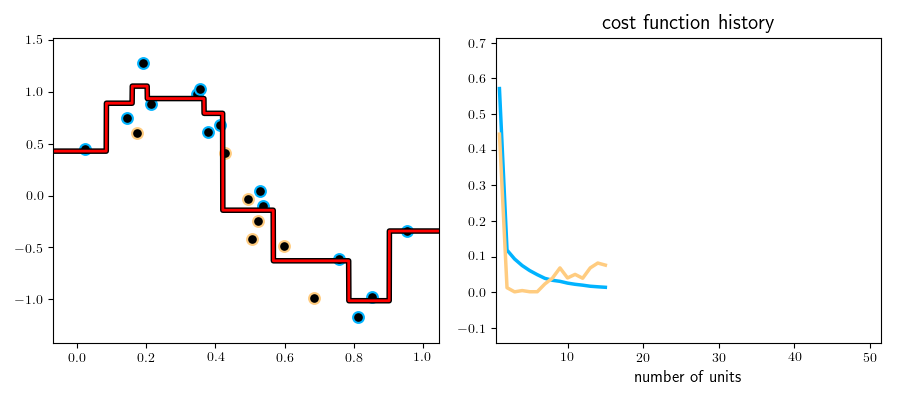
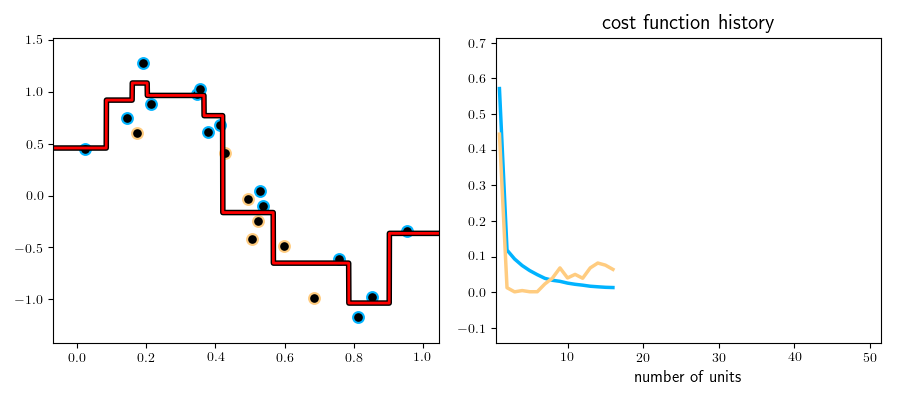
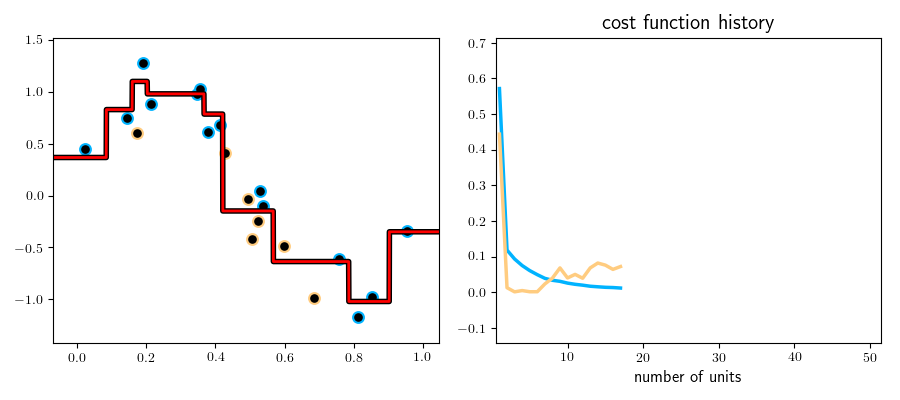
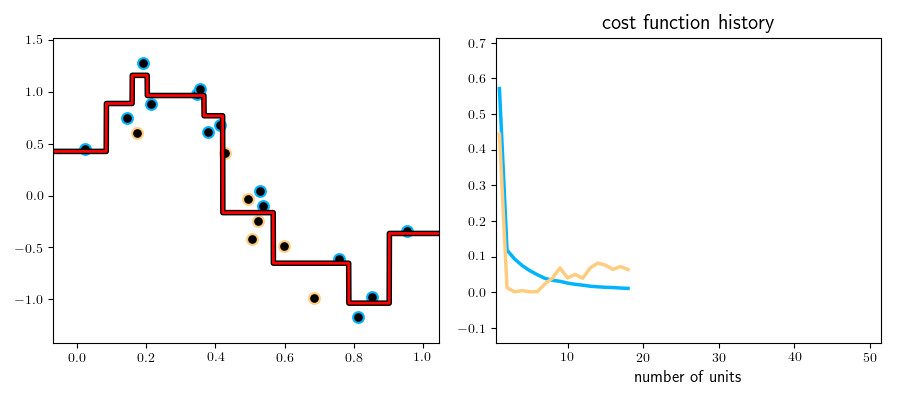
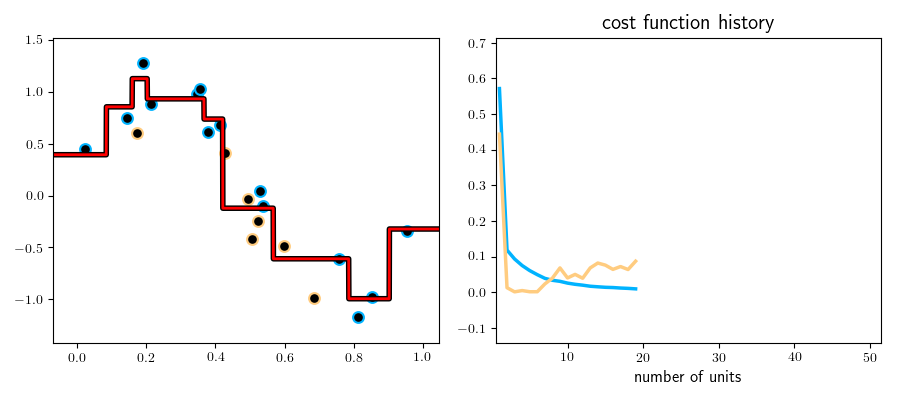
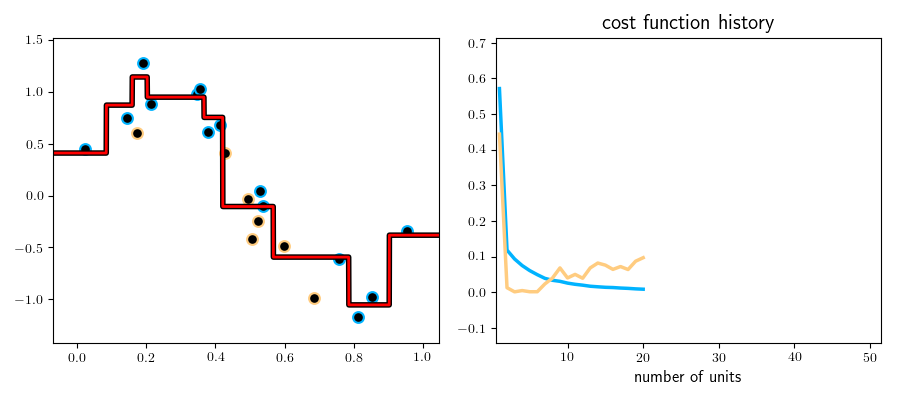
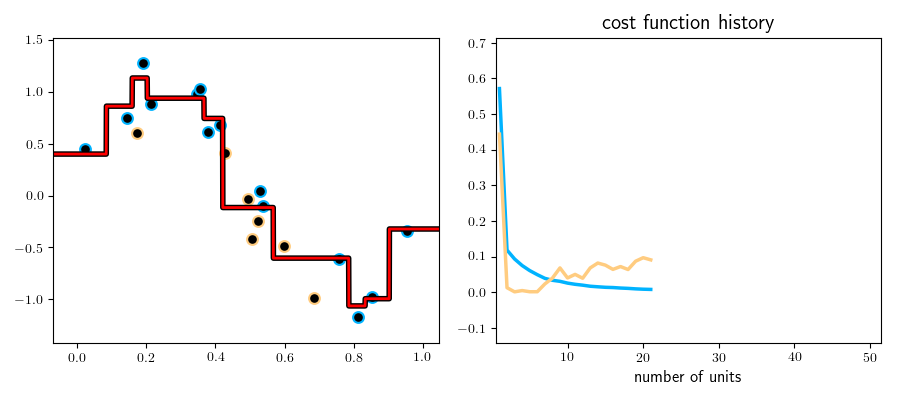
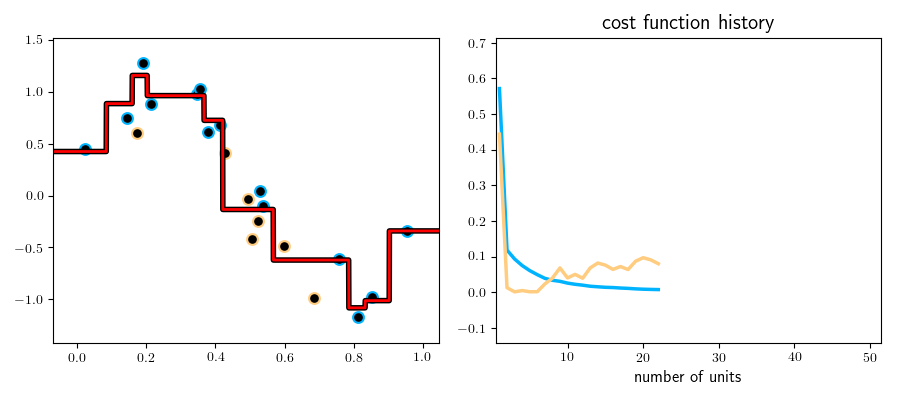
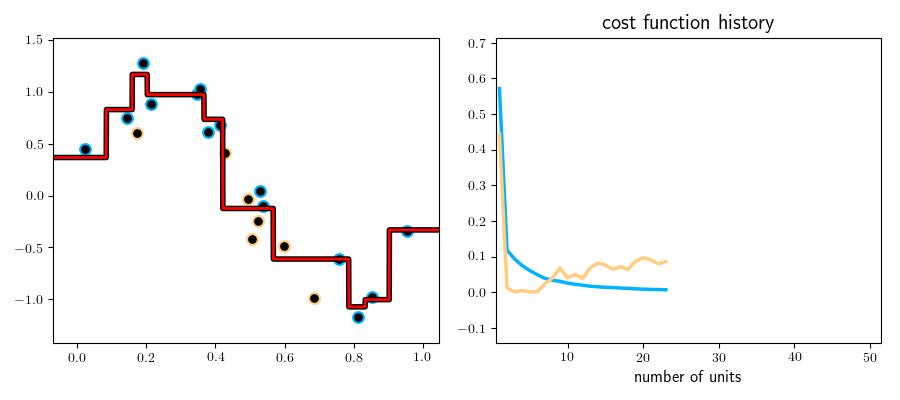
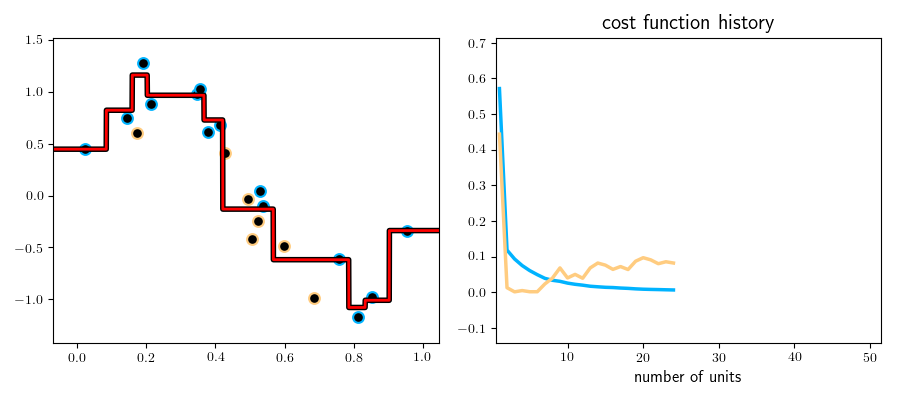
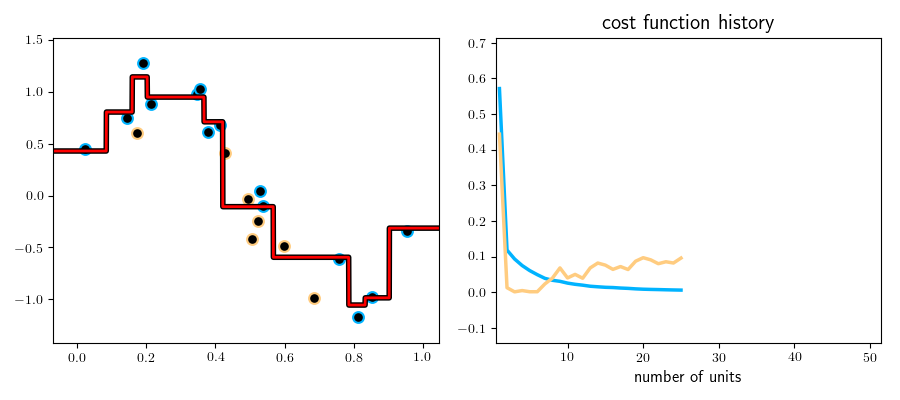
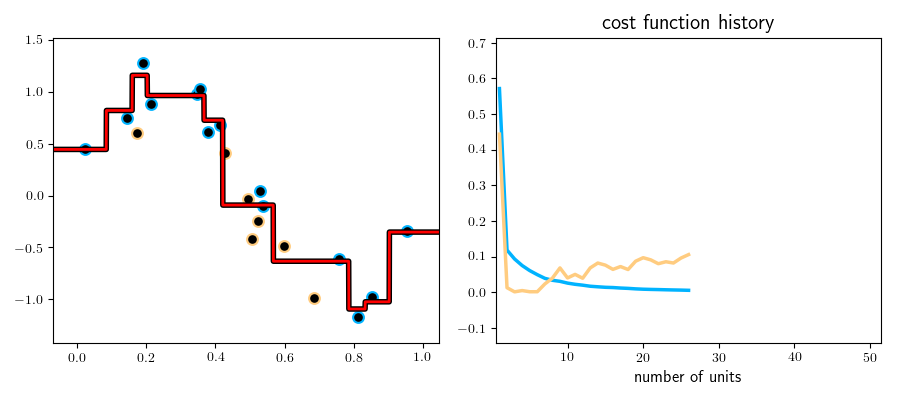
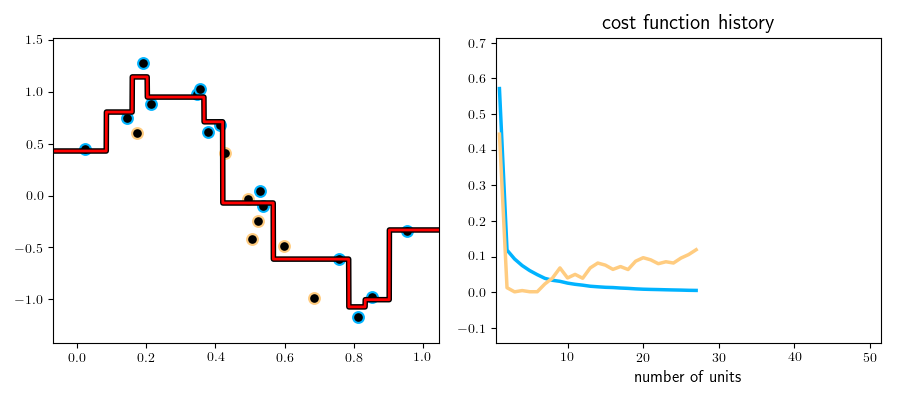
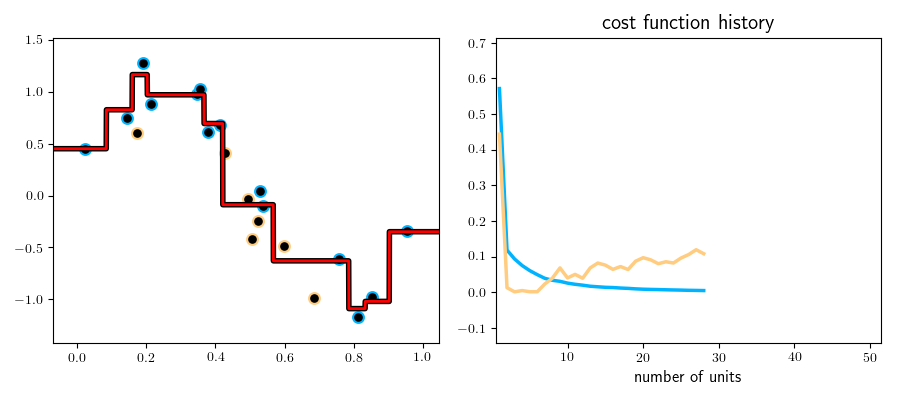
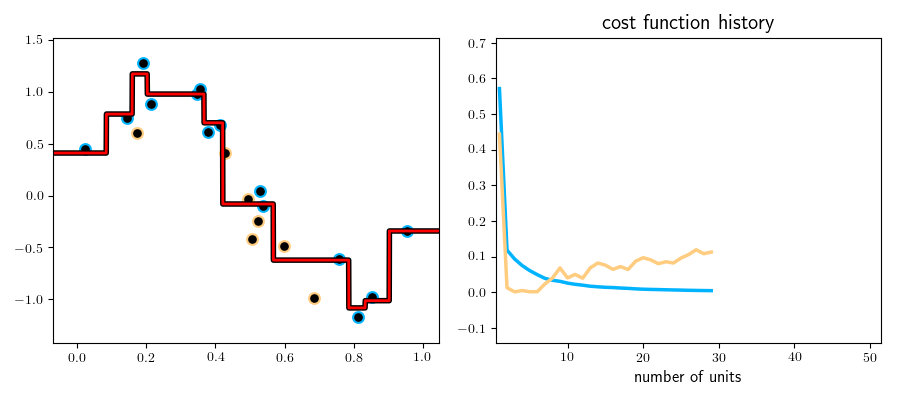
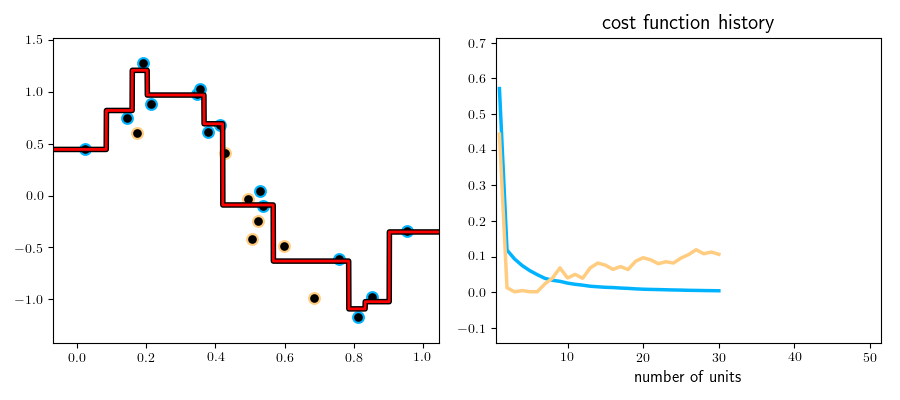
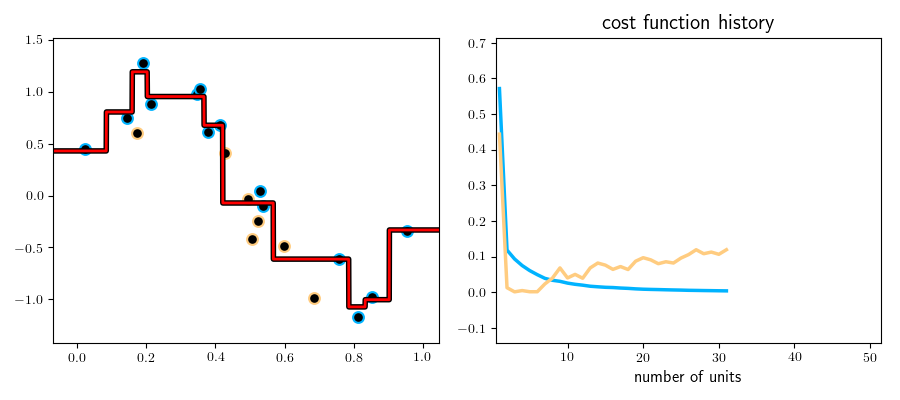
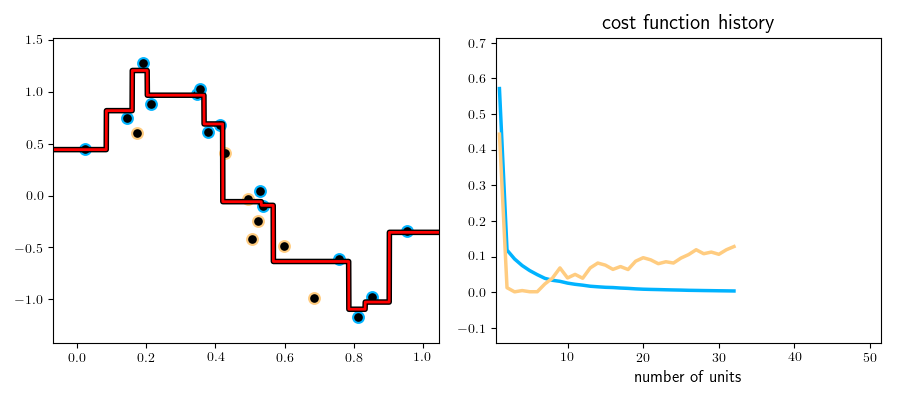
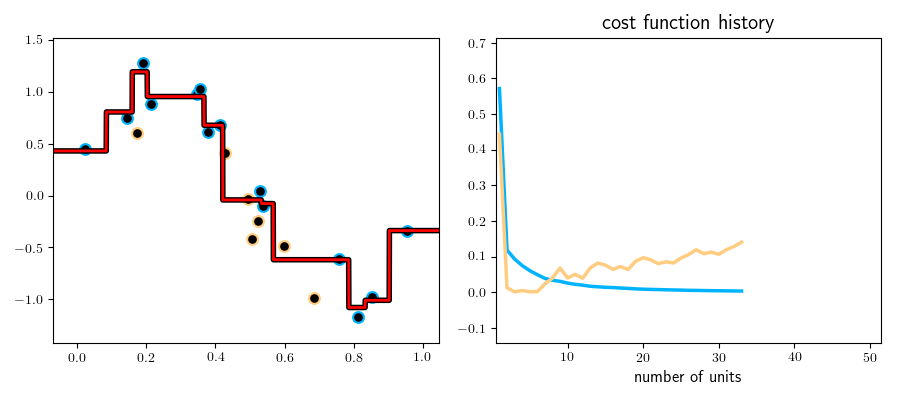
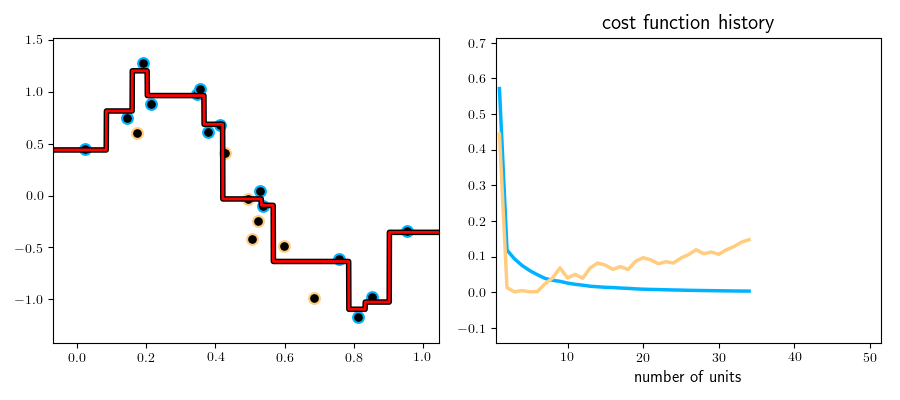
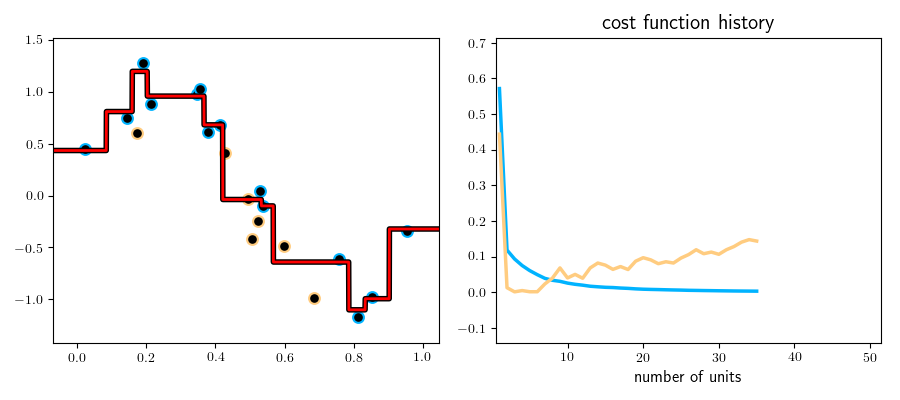
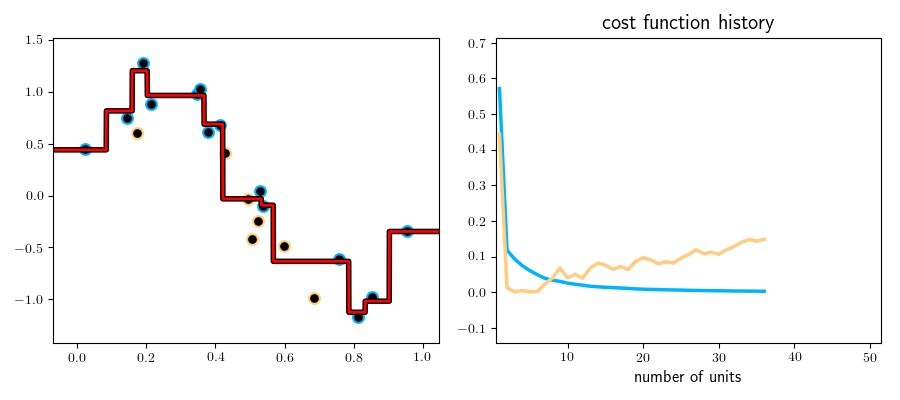
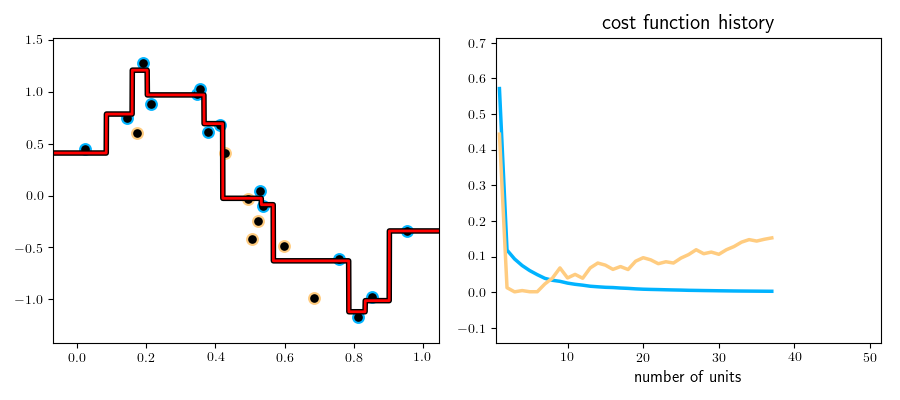
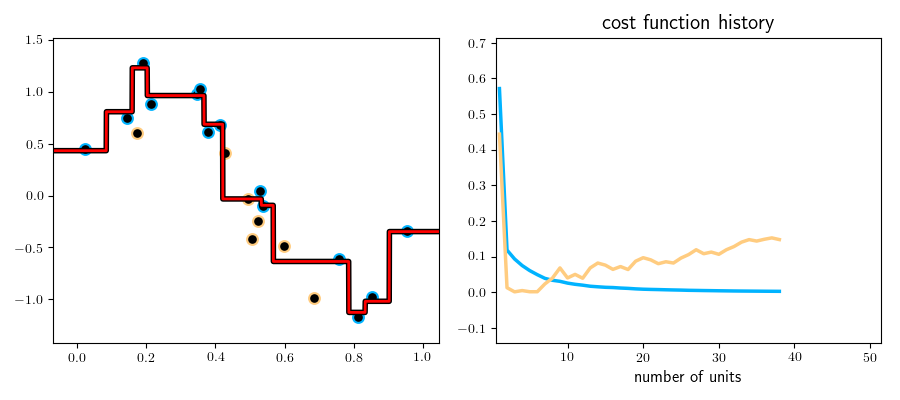
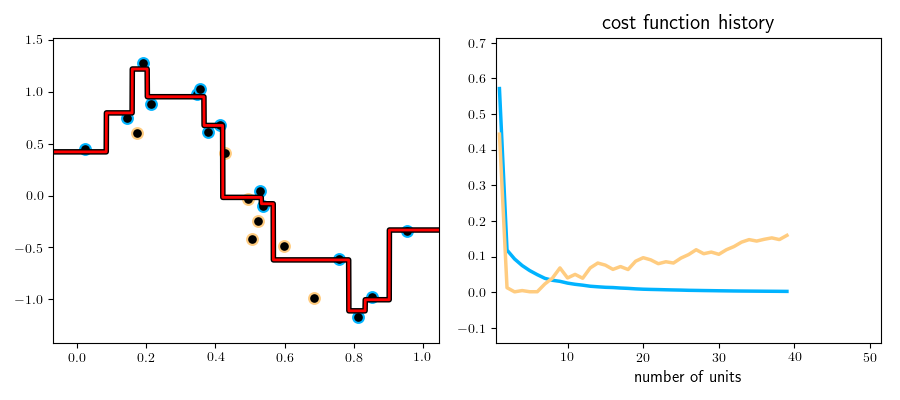
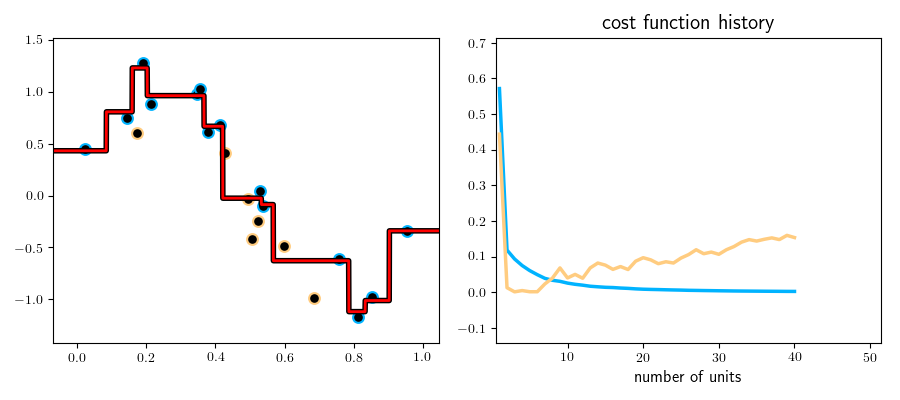
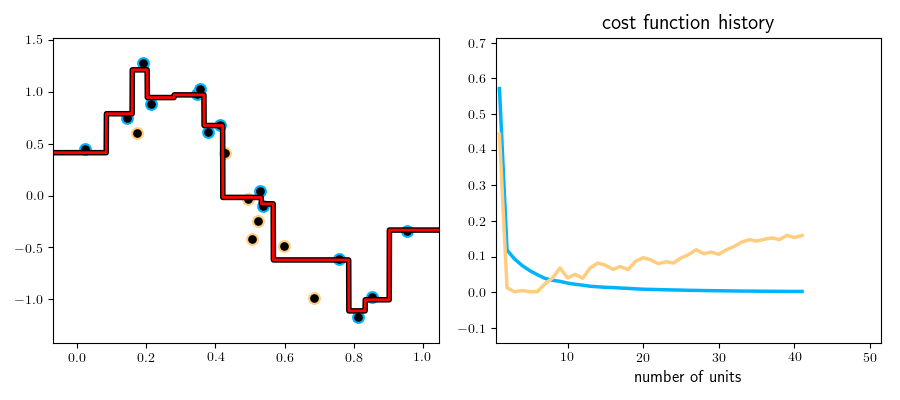
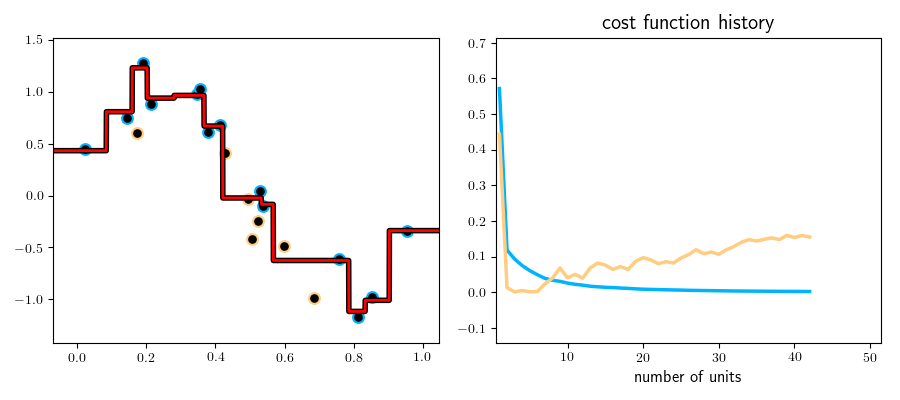
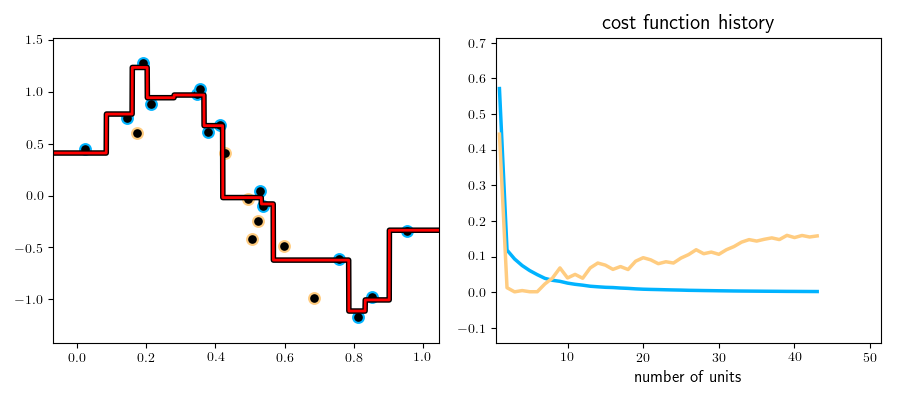
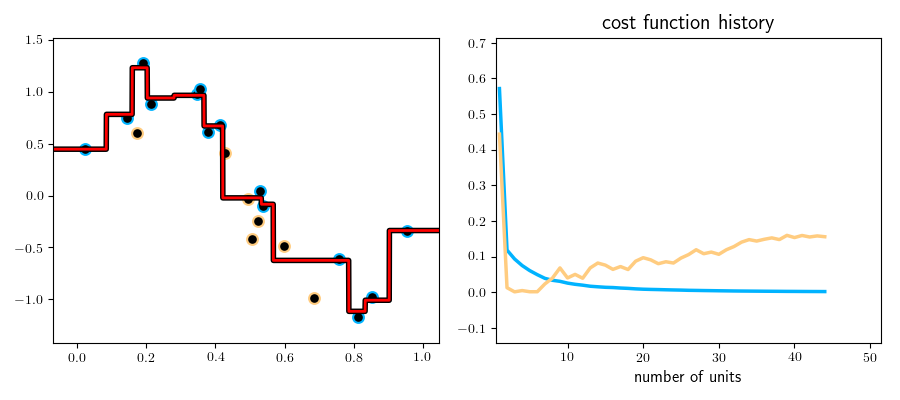
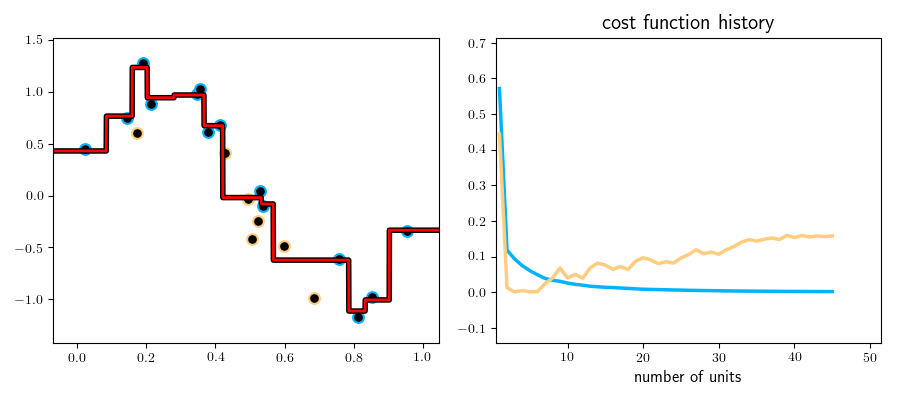
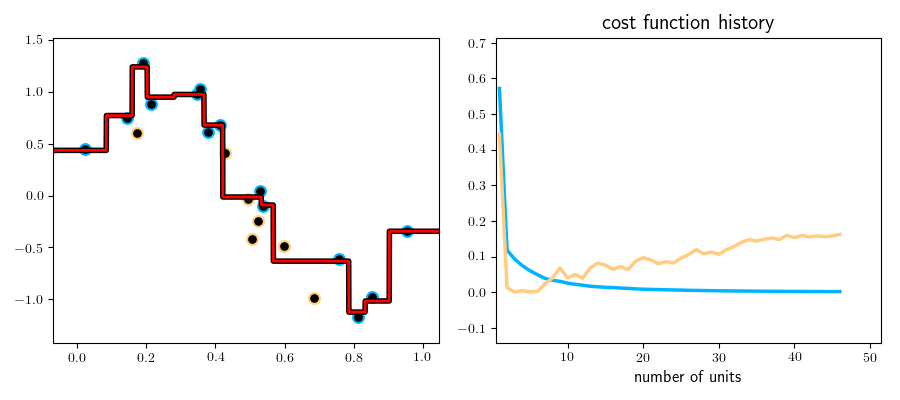
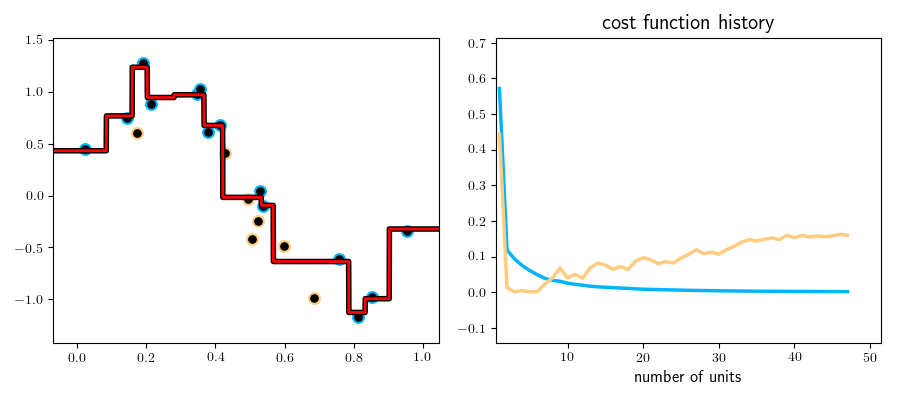
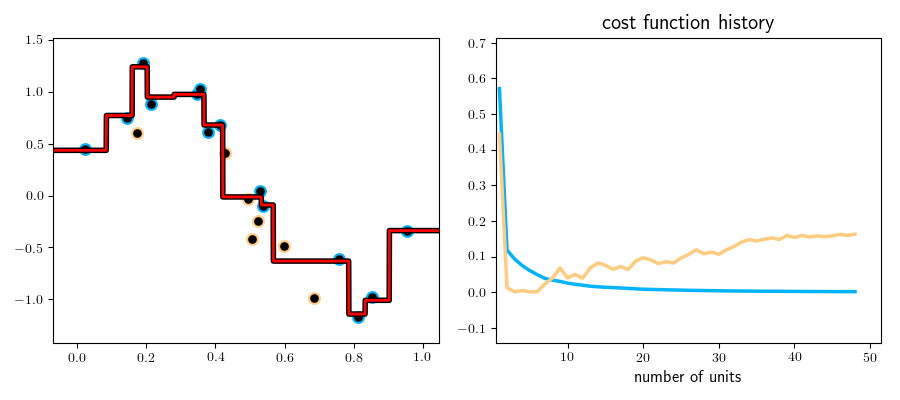
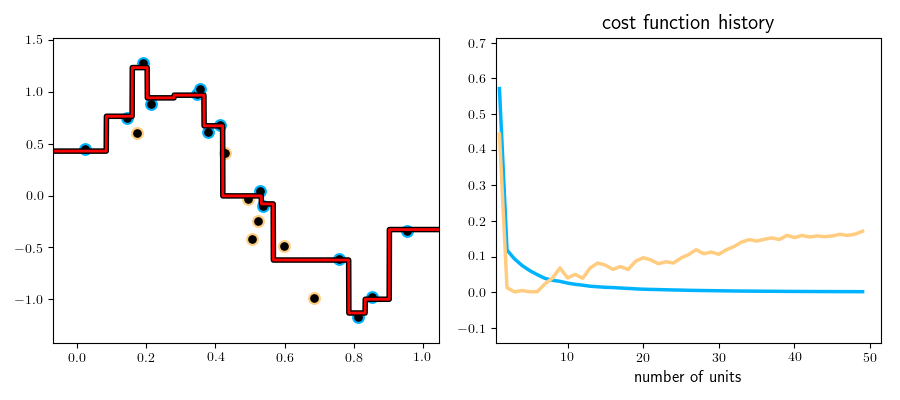
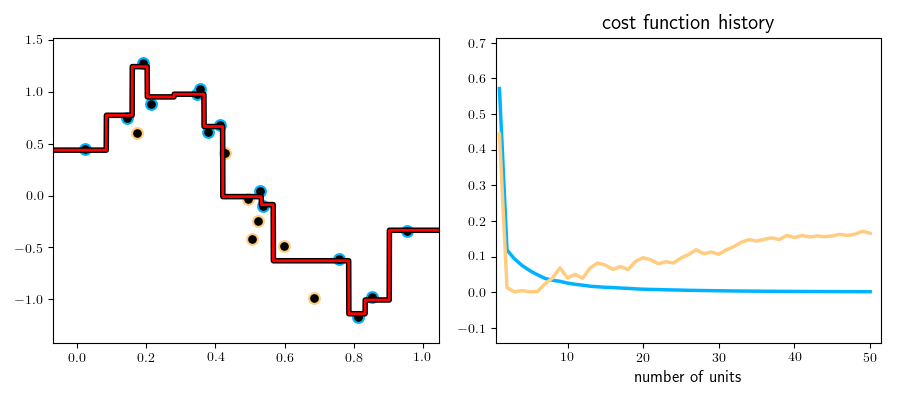
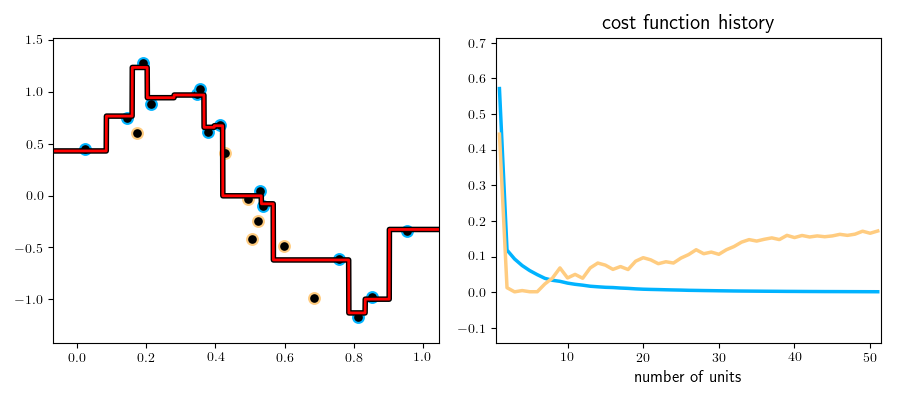

In [34]:
## This code cell will not be shown in the HTML version of this notebook
# import data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

# import booster
mylib2 = nonlin.boost_lib3.stump_booster.Setup(x,y)

# choose normalizer
mylib2.choose_normalizer(name = 'standard')

# choose normalizer
mylib2.make_train_valid_split(train_portion = 0.66)

# choose cost|
mylib2.choose_cost(name = 'least_squares')

# choose optimizer
mylib2.choose_optimizer('newtons_method',max_its=1)

# run boosting
mylib2.boost(50)

# animation
frames = 51
anim = nonlin.boosting_regression_animators_v2.Visualizer(csvname)
anim.animate_trainval_boosting(mylib2,frames)

#### <span style="color:#a50e3e;">Example 2. </span> Boosting classification using single layer network units

In this example we illustrate the same kind of boosting for two-class classification using using a dataset of $99$ datapoints that has a roughly circular decision boundary (this dataset was first used in Example 2 of the previous Section).  We split the data randomly into $\frac{2}{3}$ training and $\frac{1}{3}$ validation and employ single hidden layer `tanh` units for boosting.  Once again we animate this process over a range boosting steps - here we perform of $30$ of them - where we add one unit at-a-time.  As you move the slider from left to right the results of each added unit - in terms of the nonlinear decision boundary and resulting classification - are shown in the top left (where the original data is shown) , top right (where the training data alone is shown), and bottom left (where the validation data is shown) panels.  A plot showing the training / validation errors at each step of the process is shown in the bottom right panel.

Once again here, moving the slider back and forth, we can see that the model providing the smallest validation error appears to (more or less) provide the best nonlinearity / decision rule for the entire dataset (i.e., the current data as well as any data that might be generated by the same process in the future).  


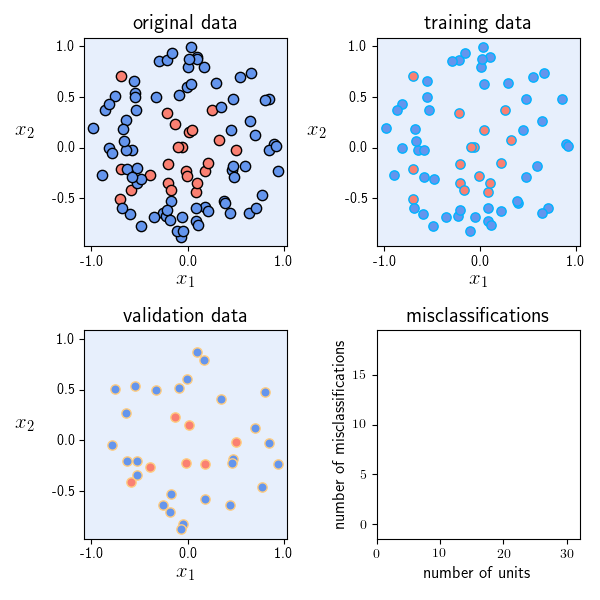
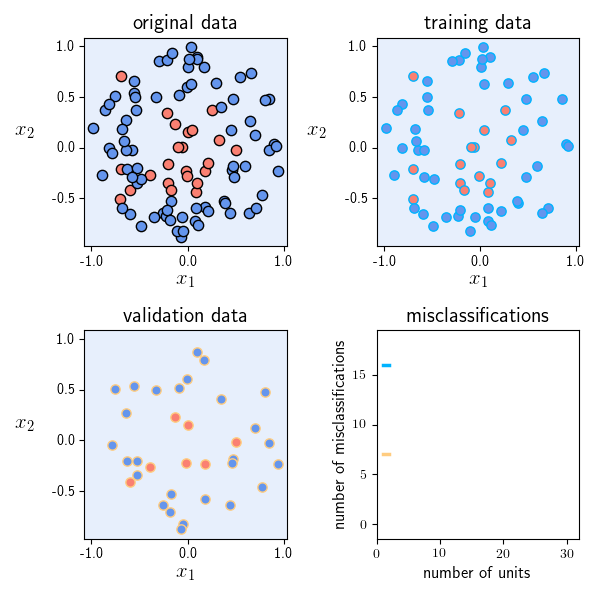
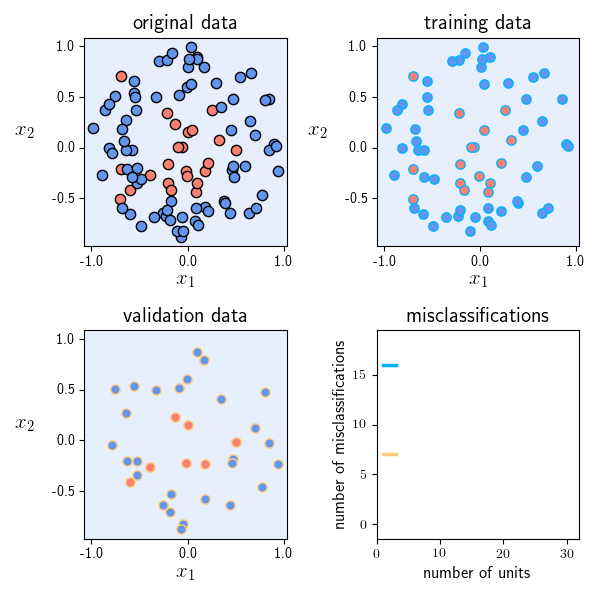
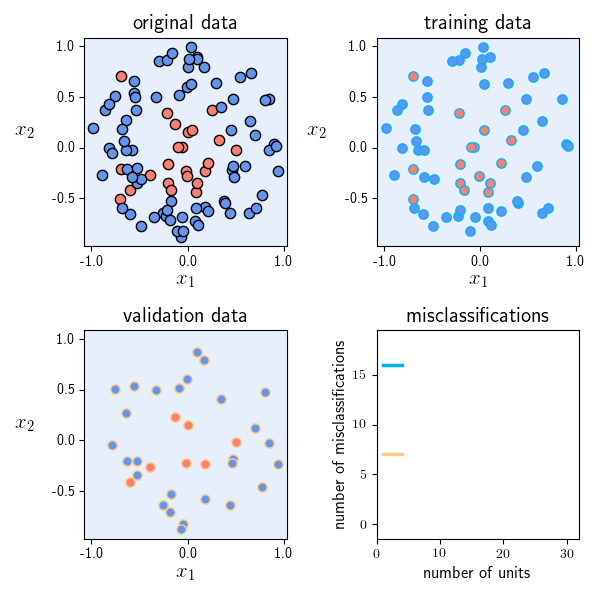
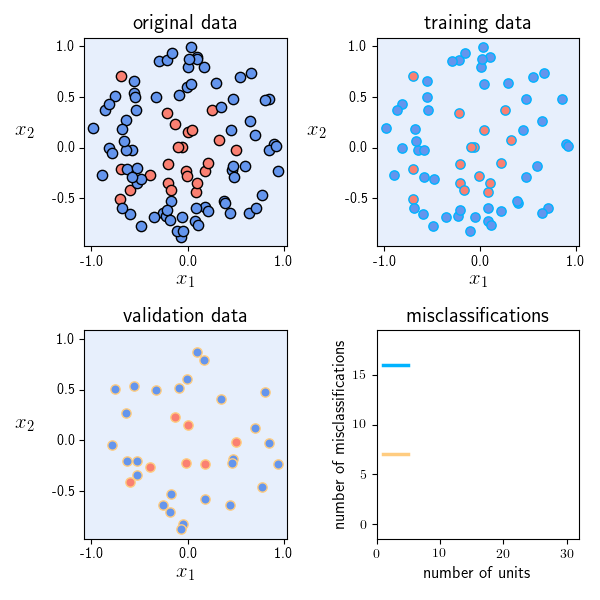
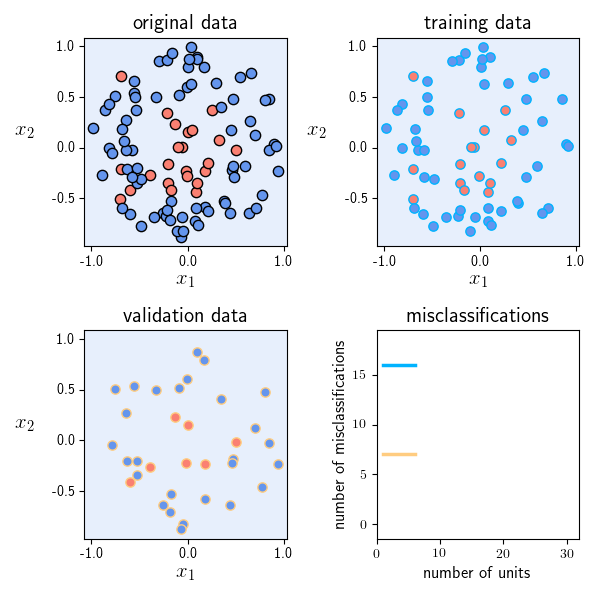
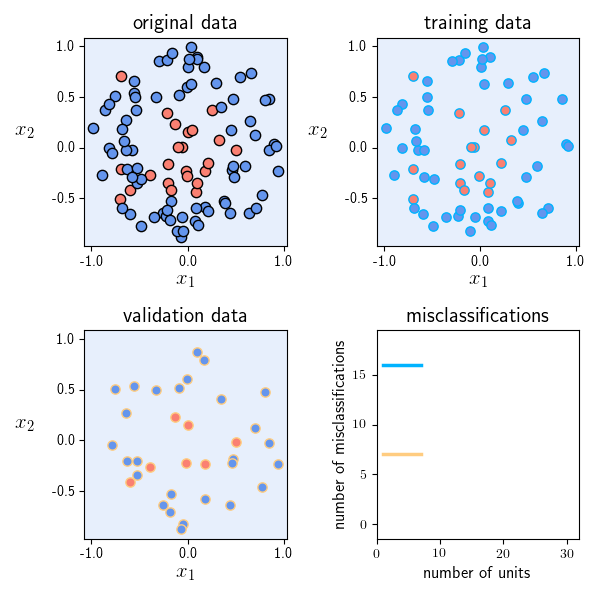
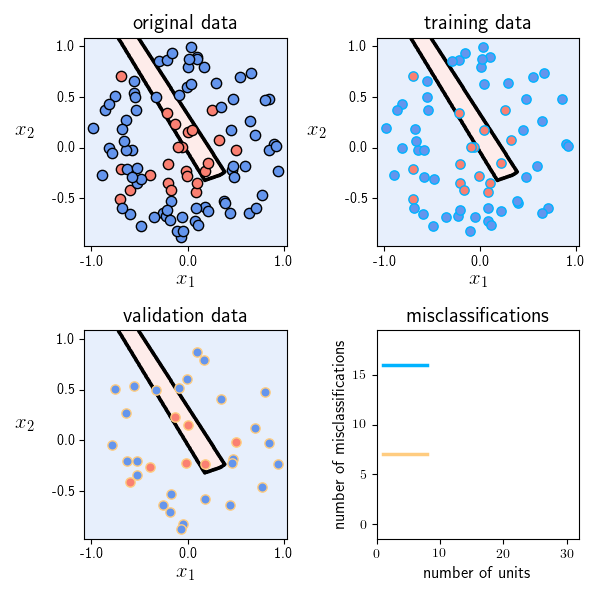
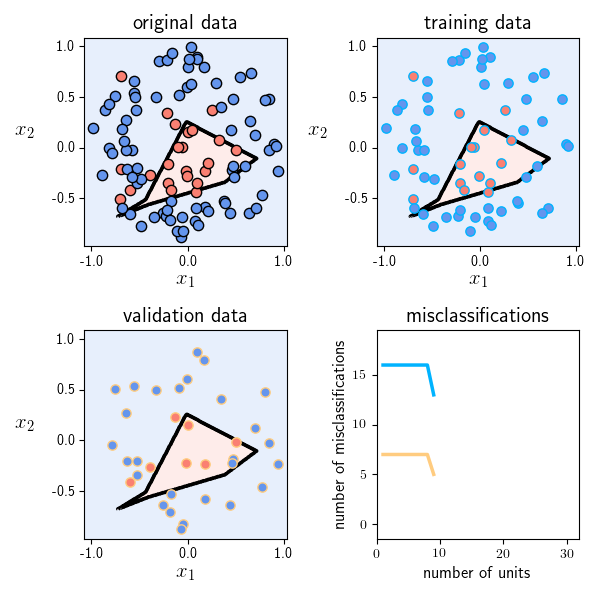
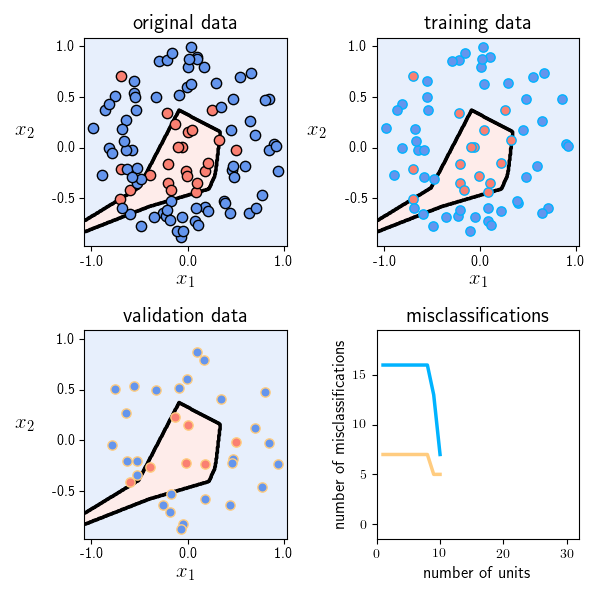
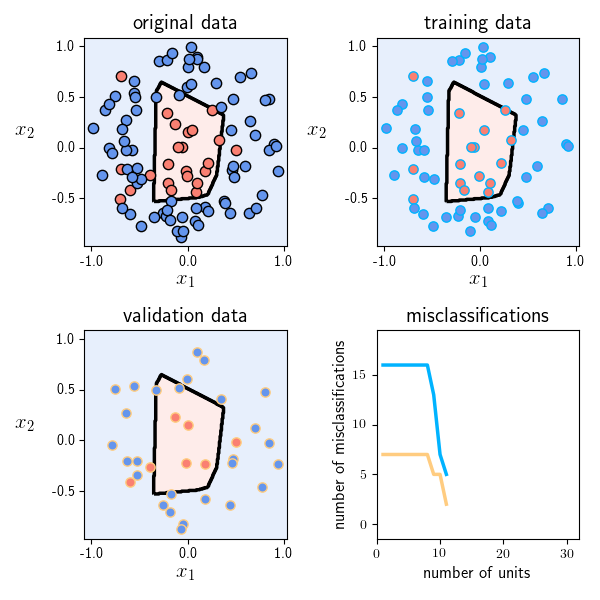
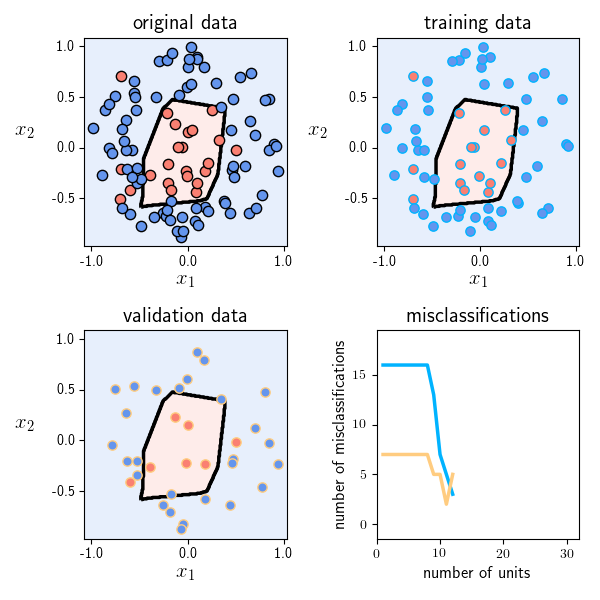
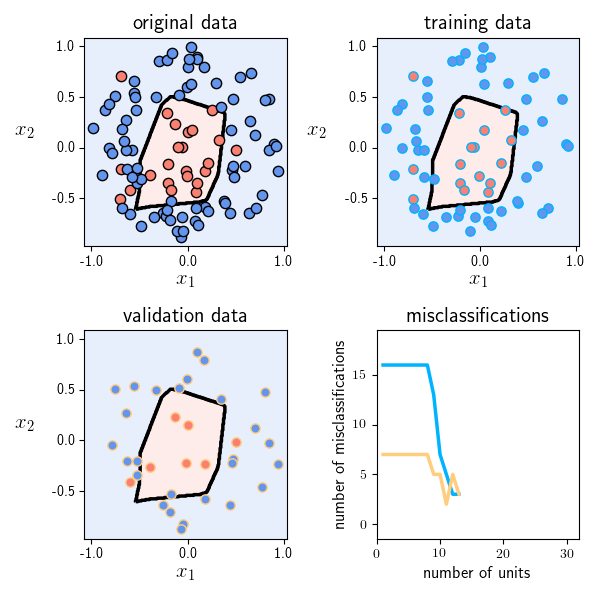
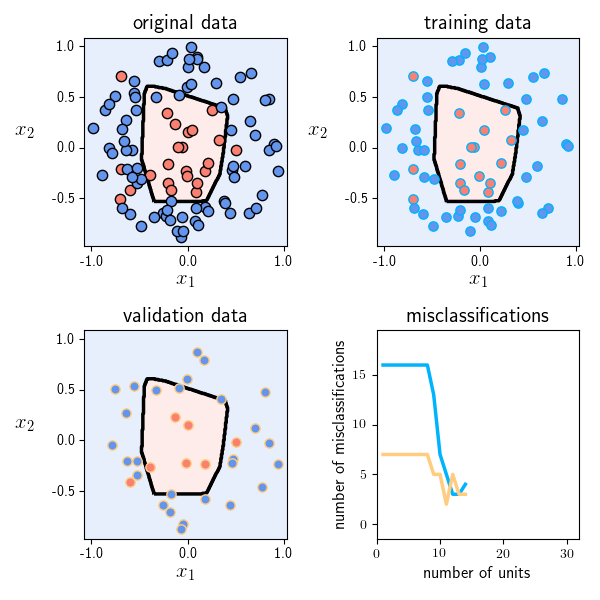
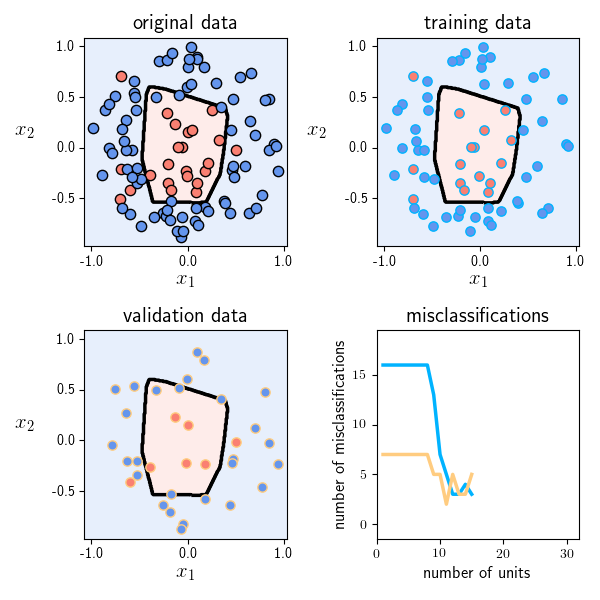
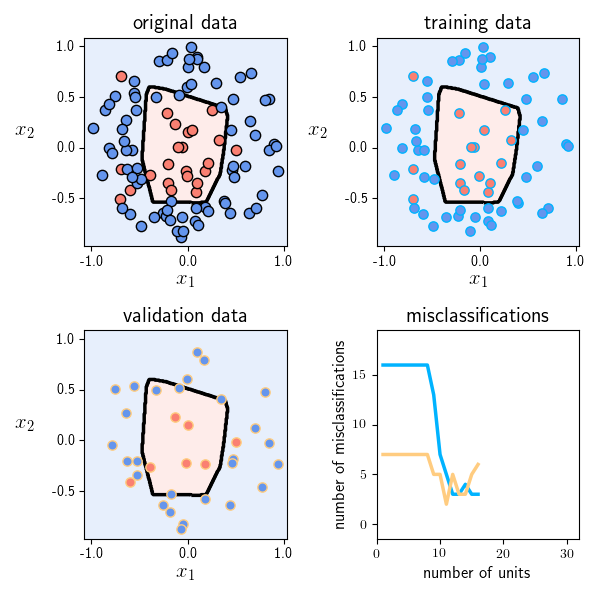
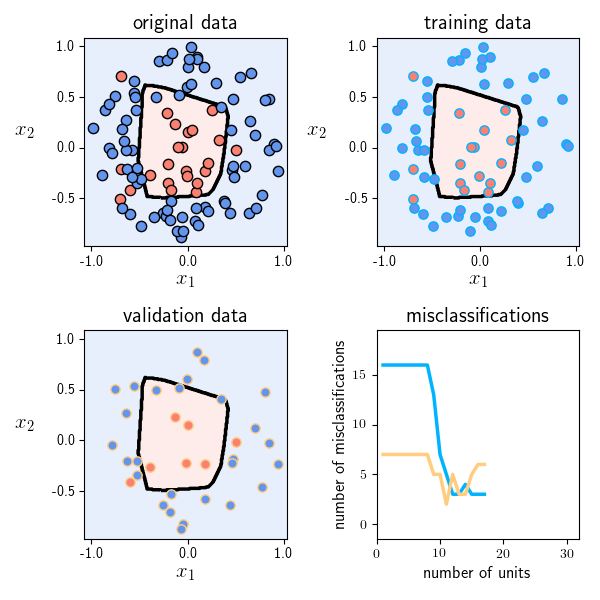
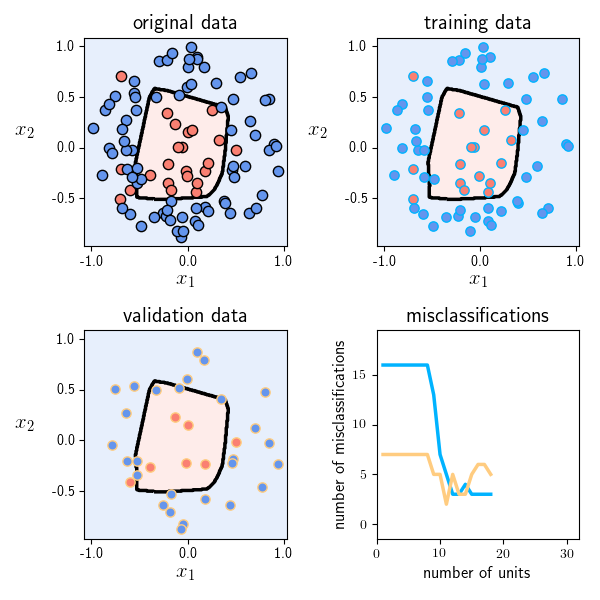
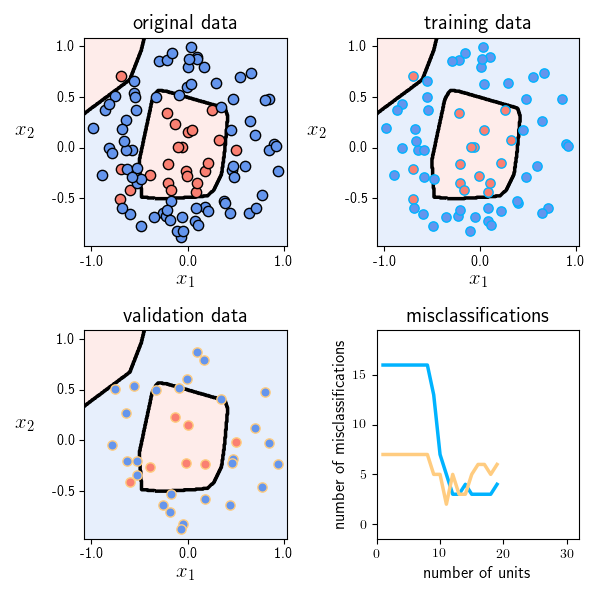
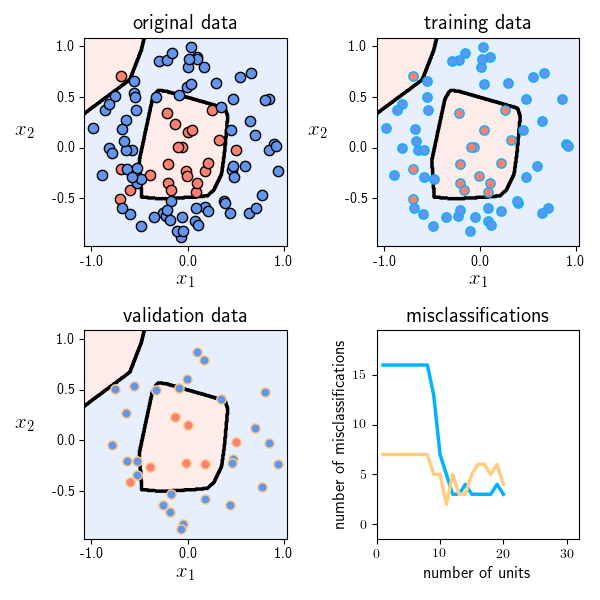
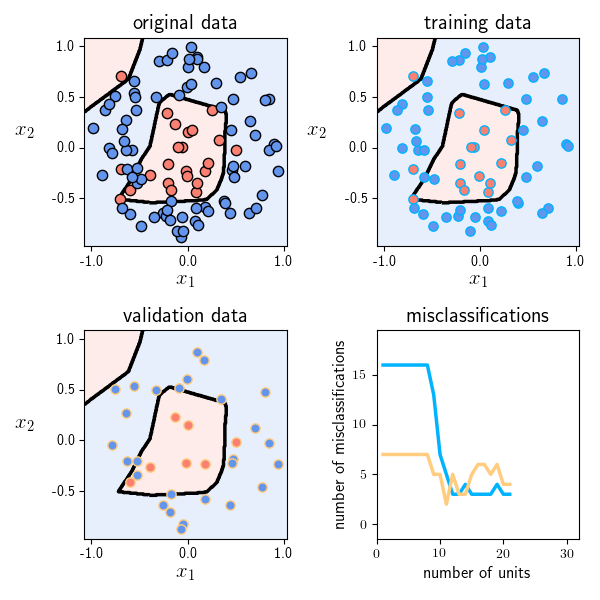
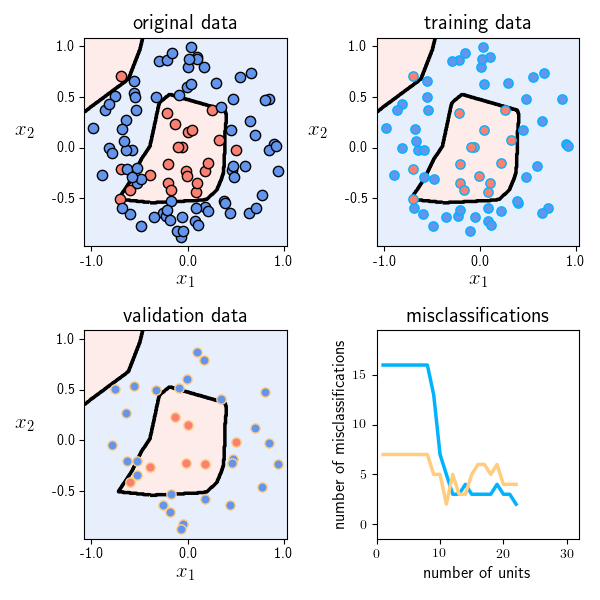
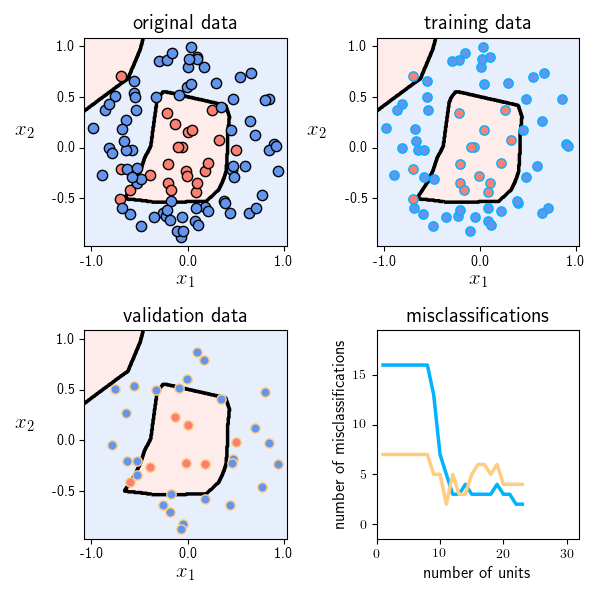
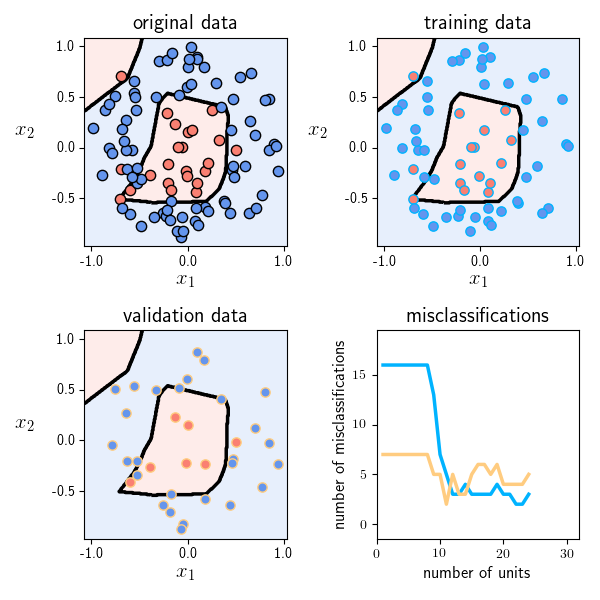
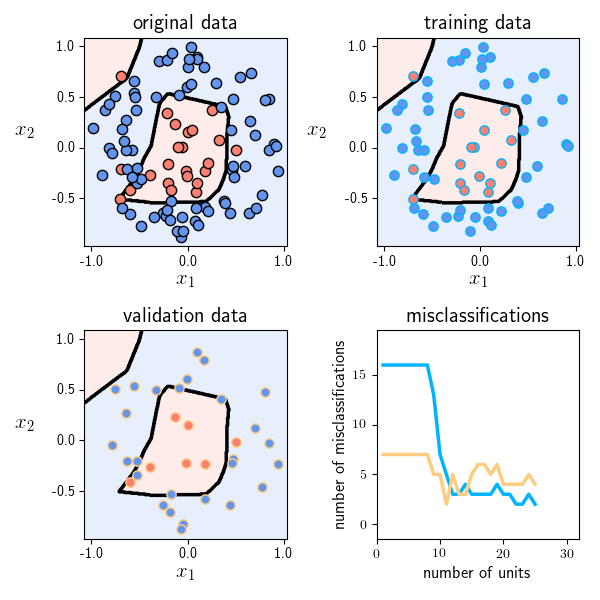
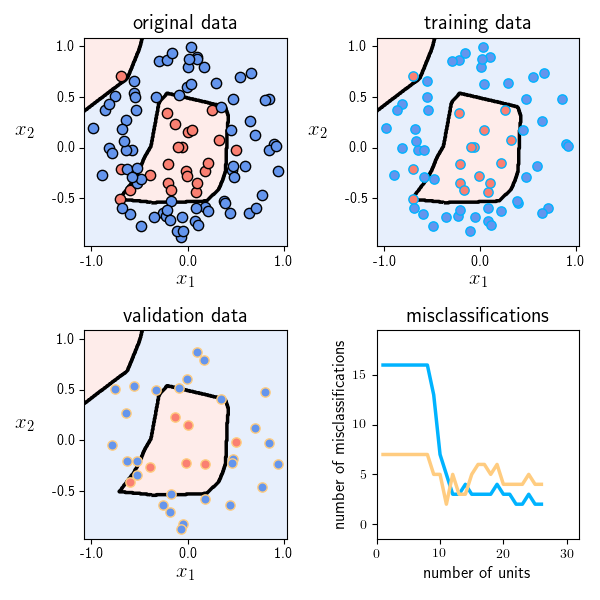
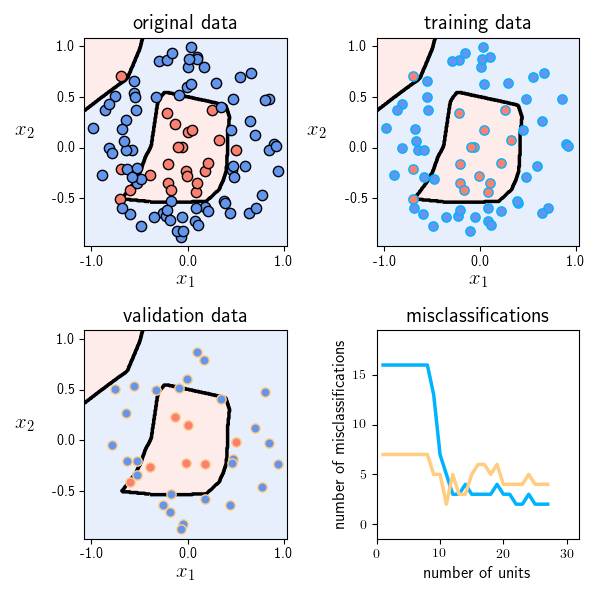
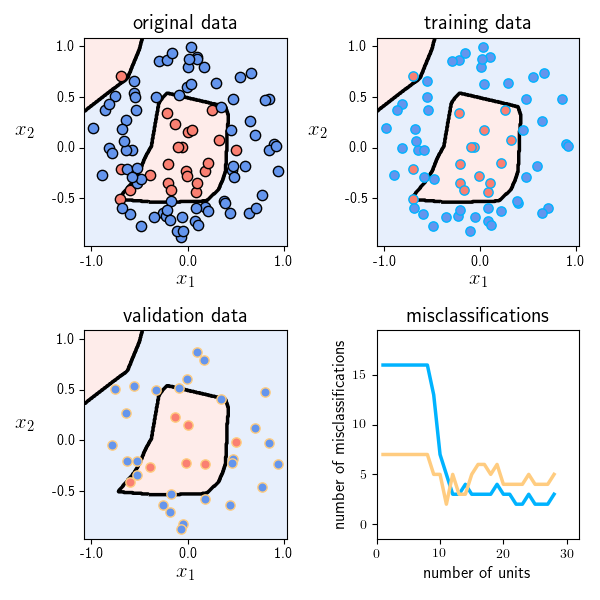
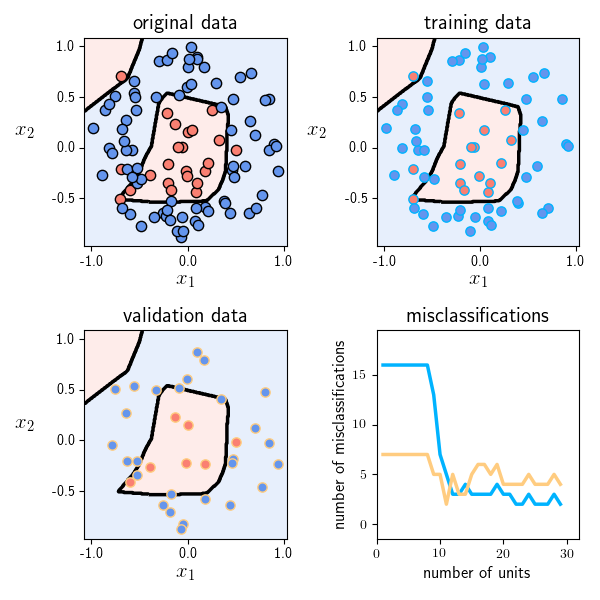
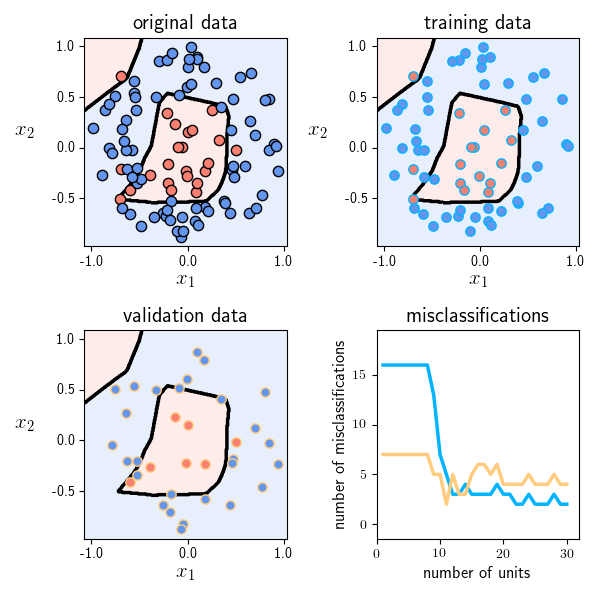
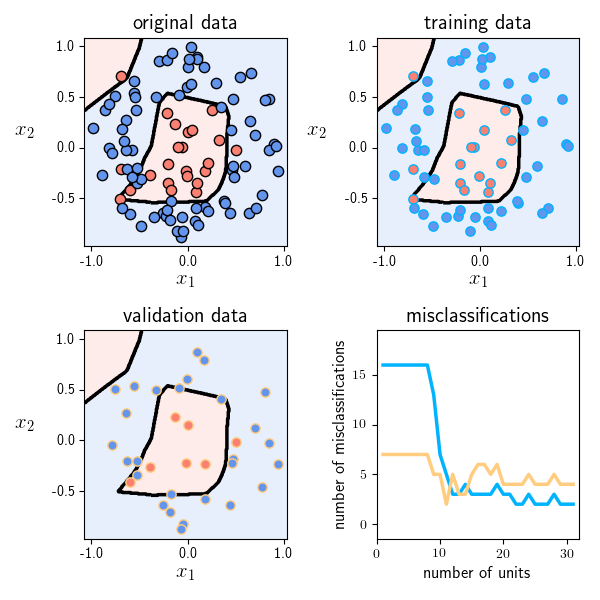

In [148]:
## This code cell will not be shown in the HTML version of this notebook
# import data
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

# import booster
mylib6 = nonlin.boost_lib3.net_booster.Setup(x,y)

# choose normalizer
mylib6.choose_normalizer(name = 'standard')

# choose normalizer
mylib6.make_train_valid_split(train_portion = 0.66)
# mylib6.x_train = mylib9.x_train
# mylib6.y_train = mylib9.y_train
# mylib6.x_valid = mylib9.x_valid
# mylib6.y_valid = mylib9.y_valid

# mylib6.train_inds = mylib9.train_inds
# mylib6.valid_inds = mylib9.valid_inds

# choose cost|
mylib6.choose_cost(name = 'softmax')

# choose optimizer
mylib6.choose_optimizer('gradient_descent',max_its=5000,alpha_choice=10**(0))

# run boosting
mylib6.boost(num_rounds=30,activation = 'relu')

# animate
frames = 31
anim = nonlin.boosting_classification_animator_v3.Visualizer(csvname)
anim.animate_trainval_boosting(mylib6,frames)

## 11.3.4  Similarity to boosting for feature selection

The careful reader will notice how similar the boosting procedure described above is to the one introduced in Section 9.5 in the context of feature selection.  Indeed fundamentally the two approaches are almost entirely the same, except here we do not select from a set of given input features but *create them ourselves based on a universal approximator*.  Additionally here instead of our main concern with boosting being *human interpretability* of a machine learning model, as it was in Section 9.5, here we use boosting as a tool for cross-validation.  This means that unless we specifically prohibit it from occuring we can indeed select the same feature multiple times in the boosting process here - that is when applying boosting to the problem of cross-validation employing nonlinear features.  

These two use-cases for boosting - feature selection and cross-validation - can occur together, albeit tyipcally in the context of linear modeling as detailed in Section 9.5.  Often in such instances cross-validation is used with a linear model as a way of automatically selecting an appropriate number of features / rounds of boosting *with human interpretation of the resulting selected features still in mind*.  On the other hand, rarely is feature selection - in the sense described in Section 9.5 - done when employing a nonlinear model based on features from a universal approximator due to the great difficulty in the human interpretability of nonlinear features.  The rare exception to this rule is when using tree-based units which due to their simple structure can - as discussed in Section 13.5 - be more easily interpreted by humans.

## 11.3.5 The residual perspective with regression

Here we describe a common interpretation of boosting in the context of regression, that of sequentially fitting to the 'residual' of a regression dataset.  To see what this means let us study a regression cost function - here Least Squares - where we have inserted a boosted model at the $M^{th}$ step of its development

\begin{equation}
g\left(\Theta_M^{\,}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_M^{\,}\left(\mathbf{x}_p,\Theta_M^{\,}\right) - y_p\right)^2.
\end{equation}

 Suppose this boosted model has been constructed by recursively adding a single unit at each step of the boosting process.  Since our boosted model is recursive, we can write equivalently as  $\text{model}_M^{\,}\left(\mathbf{x}_p^{\,},\Theta_M^{\,}\right) =   \text{model}_{M-1}^{\,}\left(\mathbf{x}_p^{\,},\Theta_{M-1}^{\,}\right) + f_M^{\,}\left(\mathbf{x}_p\right)w_M^{\,}$ where all of the parameters of the $\left(M-1\right)^{th}$ model, $\text{model}_{M-1}$, are already tuned.  Examining just the $p^{th}$ summand of the cost function above, notice we can re-write it as
 
 \begin{equation}
\left(\text{model}_{M-1}^{\,}\left(\mathbf{x}_p^{\,},\Theta_{M-1}^{\,}\right) + f_M^{\,}\left(\mathbf{x}_p\right)w_M^{\,} - y_p^{\,} \right)^2 = \left(f_M^{\,}\left(\mathbf{x}_p\right)w_M^{\,} - \left(y_p^{\,} - \text{model}_{M-1}^{\,}\left(\mathbf{x}_p^{\,},\Theta_{M-1}^{\,}\right)\right)\right)^2.
 \end{equation}

On the right hand side we have just re-arranged terms, keeping our term with parameters that still need tuning $f_M\left(\mathbf{x}\right)w_M $ on the left and lumping all of the *fixed* quantities together - i.e., $y_p - \text{model}_{M-1}$ - on the right.  Applying this to each summand of the cost function we can write it equivalently as 

\begin{equation}
g\left(\Theta_M^{\,}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(f_M^{\,}\left(\mathbf{x}_p^{\,}\right)w_M^{\,} - \left(y_p^{\,} - \text{model}_{M-1}^{\,}\left(\mathbf{x}_p^{\,}\right)\right)\right)^2.
\end{equation}

By minimizing this error notice we look to tune the parameters of a single additional unit so that

\begin{equation}
f_M^{\,}\left(\mathbf{x}_p\right)w_M^{\,}\approx y_p^{\,} - \text{model}_{M-1}^{\,}\left(\mathbf{x}_p^{\,}\right) \,\,\,\,\, p=1,...,P
\end{equation}

or in other words, so that this fully tuned unit approximates our original output $y_p$ minus the contribution of the previous model $\text{model}_{M-1}^{\,}\left(\mathbf{x}_p^{\,},\Theta_{M-1}^{\,}\right)$.  This quantity - the difference between our original output and the contribution of the $\left(M-1\right)^{th}$ model - is often called the *residual*.  It is the 'leftovers', what is left to represent after learning after subtracting off what was learned by the $\left(M-1\right)^{th}$ model.

#### <span style="color:#a50e3e;">Example 2. </span> Boosting regression and 'fitting to the residual'

Below we animate the process of boosting $M = 5000$ single layer `tanh` units to a one dimensional input regression dataset.  In the left panel we show the dataset along with the fit provided by $\text{model}_m$ at the $M^{th}$ step of boosting.  In the right panel we plot the *residual* at the same step, as well as the fit provided by the corresponding $M^{th}$ *unit* $f_M$.  As you pull the slider from left to right the run of boosting progresses, with the fit on the original data improving and while (simultaneously) the residual shrinks.


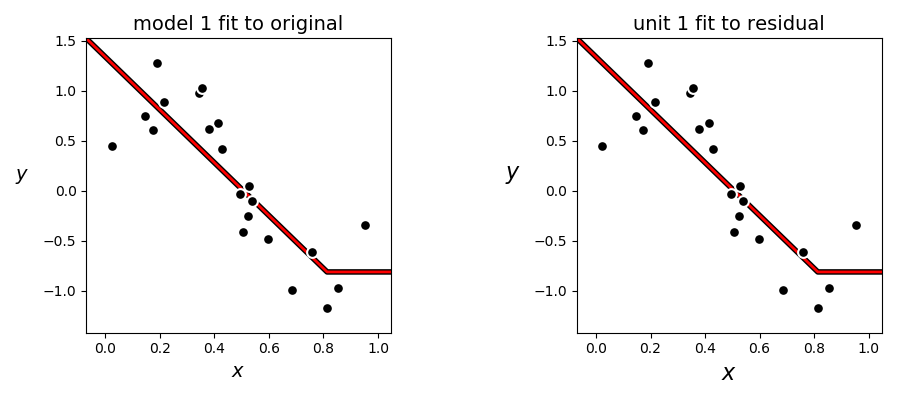
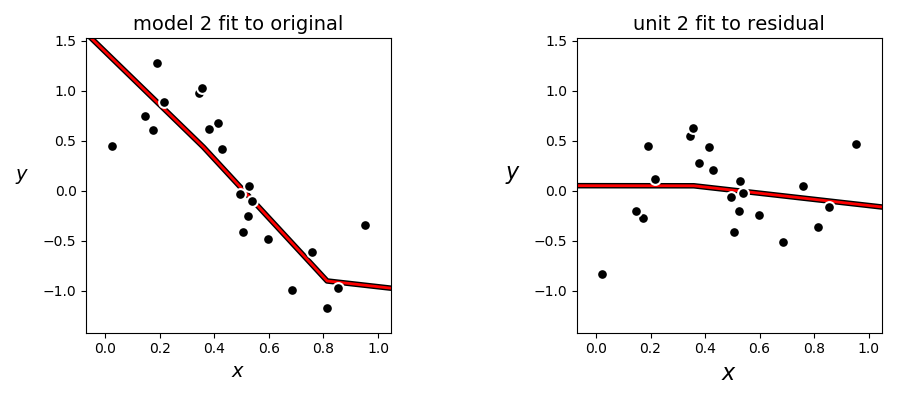
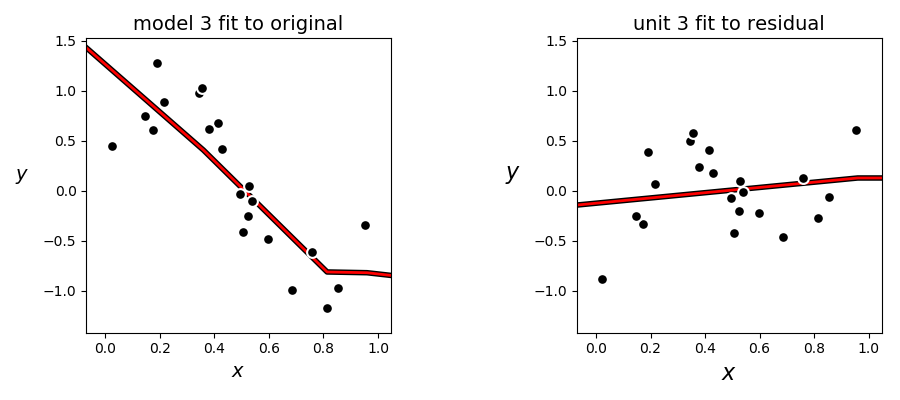
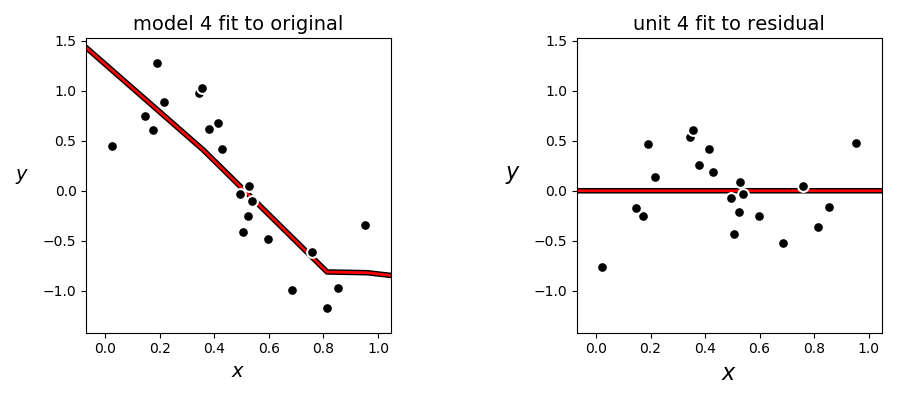
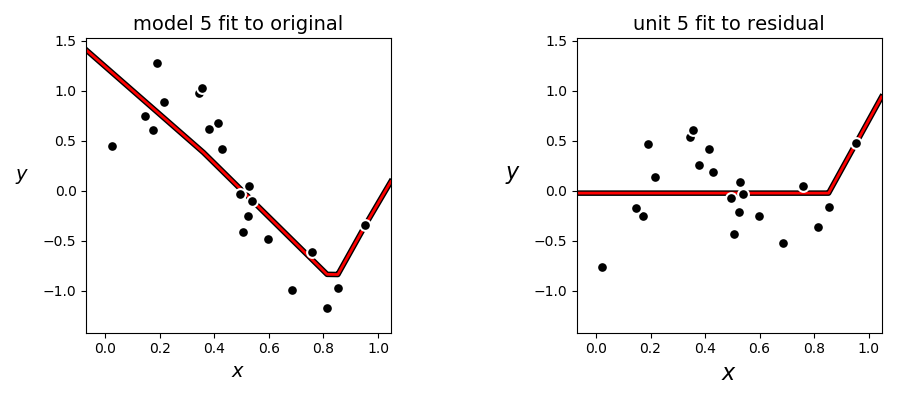
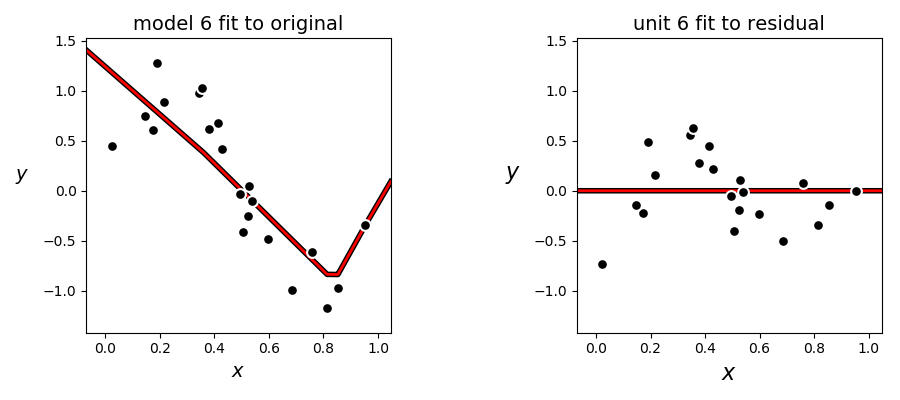
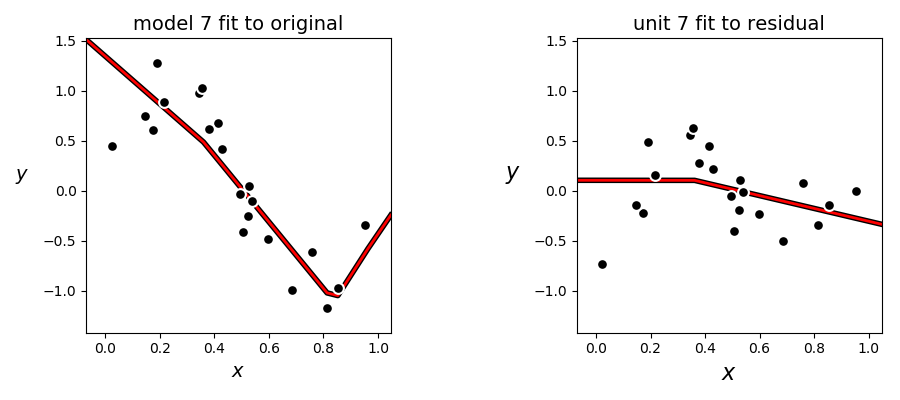
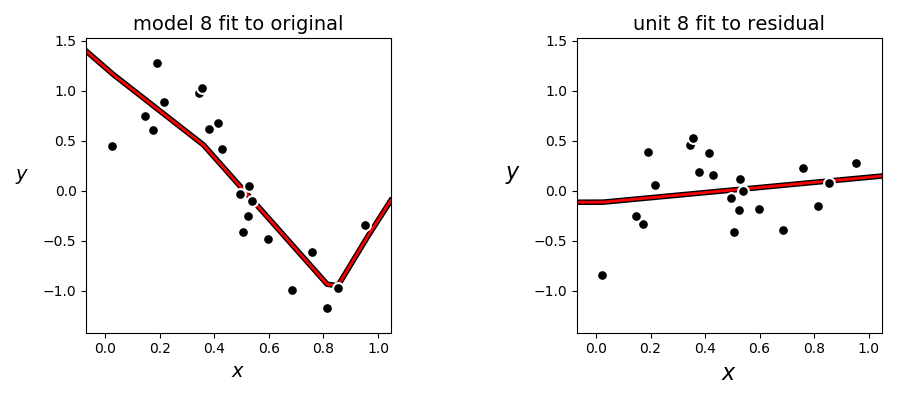
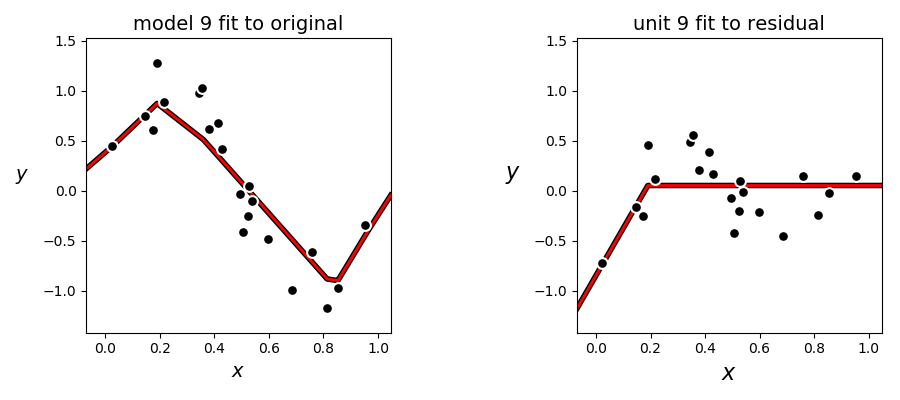
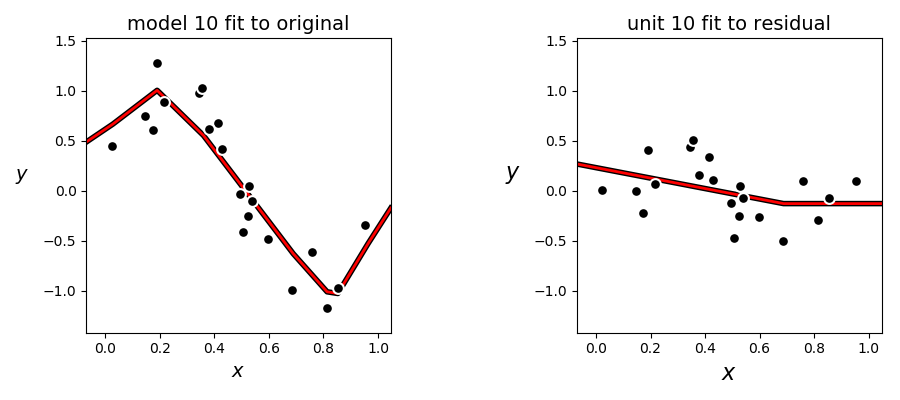

In [20]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

# boosting procedure
num_units = 10
runs2 = []
for j in range(num_units):    
    # import the v1 library
    mylib2 = nonlib.boost_lib3.net_booster.Setup(x,y)
    
    # choose normalizer
    mylib2.choose_normalizer(name = 'standard')

    # choose normalizer
    mylib2.make_train_valid_split(train_portion = 1)

    # choose cost
    mylib2.choose_cost(name = 'least_squares')

    # choose optimizer
    mylib2.choose_optimizer('gradient_descent',max_its=10000,alpha_choice = 10**(-1))
    
    # choose activation 
    mylib2.choose_activation(activation = 'relu')
    
    # run boosting
    mylib2.boost(1,verbose=False)
    mylib2.model = mylib2.models[-1]

    # add model to list
    runs2.append(copy.deepcopy(mylib2))
    
    # cut off output given model
    normalizer = mylib2.normalizer
    ind = np.argmin(mylib2.train_cost_vals[0])
    y_pred =  mylib2.models[-1](mylib2.normalizer(x))
    y -= y_pred

# animate the business
frames = num_units
demo2 = nonlib.boosting_regression_animators_v3.Visualizer(csvname)
demo2.animate_boosting(runs2,frames)